## Idea:
 The Dataset with text values are already labelized, so will be dropping all those columns 
 
 The following notebook was run on colab and then used in local computer to add comments
 
 Used Bayesian Optimization to get optimal parameters for RandomForestClassifier(RFC)
 
 Tried with XgBoost ,but the colab kept on disconnecting show memory error 
 
 The reason going with RFC and not with any crazy deep net is because,its labelled dataset with good number of features already defined,where a simple ensemble model is more than enough 

## Steps:
    1. Installing and Importing all the given dependencies
    2. Reading the given files
    3. Calculating the total number of Undefined(NAN) in the given excel sheet 
    4. Removing the columns which have count of NAN based on a threshold value
    5. Removing rows which contains NAN in this dataframe
    6. Selecting few columns under some criteria given in the codebook.pdf
    7. Exploring the **Gname** column 
    8. Selecting few keys in ***Gname*** based on a threshold
    9. Seeing how many of the keys were dropped and selected
    10. Encoding all the txt format data to labelEncoder
    11. Splitting the data into different categories and then passing them into RFC
    12. Understanding the accuracies and other values

In [4]:
file_name="globalterrorismdb_0718dist.xlsx"
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import precision_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import classification_report,confusion_matrix
from bayes_opt import BayesianOptimization
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
df = pd.read_excel(file_name)

In [6]:
df.head(5)

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaT,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaT,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaT,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaT,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaT,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


In [7]:
len(df.columns)

135

A total of 135 columns are present ,in this given dataset,by a quick look in the dataset ,we can see most of them doesn't contain the actual data(contains NAN).Pre-proceesing will be required to change these values.We have to replace these NAN values with proper set of values

### Explanation of each columns in the dataframe

https://www.start.umd.edu/gtd/downloads/Codebook.pdf



We will see the total number of null values present in the entire dataframe.

In [9]:
df.isnull().sum().sort_values(ascending=False).head(10)

gsubname3           181671
weapsubtype4_txt    181621
weapsubtype4        181621
weaptype4           181618
weaptype4_txt       181618
claimmode3          181558
claimmode3_txt      181558
gsubname2           181531
claim3              181373
guncertain3         181371
dtype: int64

Sum of all Missing values in each columns,meaning that values are not represented at all.We can see that most of them are in txt_format .As mentioned the intention to **not to use any txt format is because the data is already represented in categorical form,which makes it easier to use**

In [10]:
df2=df.drop(df.isnull().sum().sort_values(ascending=False)[df.isnull().sum().sort_values(ascending=False)>45000]
            .index,axis=1)

Dropping all those columns which have missing value more than 30% empty size .
We then take it as a new dataframe.
The reason for dropping columns with have **30% empty** dataset is because we won't be having much data values to replace it with,and if we change with some other metric values,we might change the **variance or even distribution of the data** of that column,which might change what they actually represent.

In [11]:
df2.head(5)

,eventid,iyear,imonth,iday,extended,country,country_txt,region,region_txt,provstate,...,weapsubtype1_txt,nkill,nwound,property,ishostkid,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY
0,197000000001,1970,7,2,0,58,Dominican Republic,2,Central America & Caribbean,NaN,...,NaN,1.0,0.0,0,0.0,PGIS,0,0,0,0
1,197000000002,1970,0,0,0,130,Mexico,1,North America,Federal,...,NaN,0.0,0.0,0,1.0,PGIS,0,1,1,1
2,197001000001,1970,1,0,0,160,Philippines,5,Southeast Asia,Tarlac,...,NaN,1.0,0.0,0,0.0,PGIS,-9,-9,1,1
3,197001000002,1970,1,0,0,78,Greece,8,Western Europe,Attica,...,Unknown Explosive Type,NaN,NaN,1,0.0,PGIS,-9,-9,1,1
4,197001000003,1970,1,0,0,101,Japan,4,East Asia,Fukouka,...,NaN,NaN,NaN,1,0.0,PGIS,-9,-9,1,1


Text(0,0.5,'Total count of the nan in columns ')

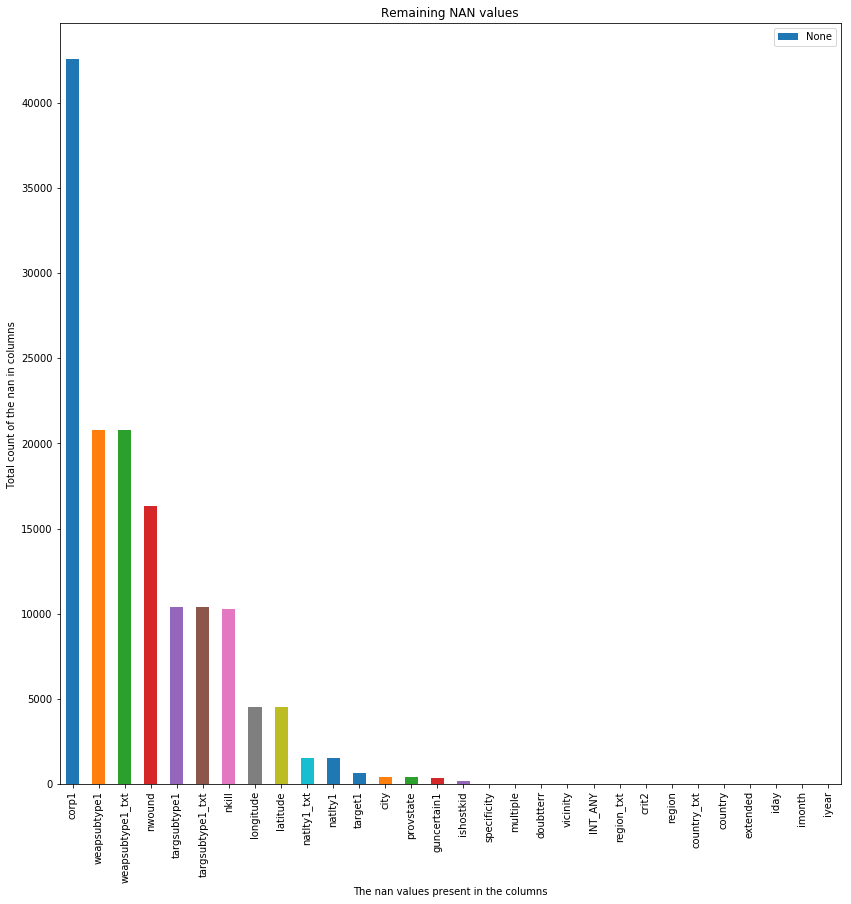

In [12]:
remaining_nan_values=df2.isnull().sum().sort_values(ascending=False)
ax=remaining_nan_values[0:30].plot("bar",title="Remaining NAN values",figsize=(14,14),legend=True)
ax.set_xlabel("The nan values present in the columns")
ax.set_ylabel("Total count of the nan in columns ")

We can see that they are still null values present ,we will remove these values as well(removing the rows which has still the null values) 

In [13]:
df2.dropna(inplace=True)

In [14]:
df2.head(5)

,eventid,iyear,imonth,iday,extended,country,country_txt,region,region_txt,provstate,...,weapsubtype1_txt,nkill,nwound,property,ishostkid,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY
5,197001010002,1970,1,1,0,217,United States,1,North America,Illinois,...,Unknown Gun Type,0.0,0.0,1,0.0,Hewitt Project,-9,-9,0,-9
6,197001020001,1970,1,2,0,218,Uruguay,3,South America,Montevideo,...,Automatic or Semi-Automatic Rifle,0.0,0.0,0,0.0,PGIS,0,0,0,0
7,197001020002,1970,1,2,0,217,United States,1,North America,California,...,Unknown Explosive Type,0.0,0.0,1,0.0,Hewitt Project,-9,-9,0,-9
8,197001020003,1970,1,2,0,217,United States,1,North America,Wisconsin,...,Molotov Cocktail/Petrol Bomb,0.0,0.0,1,0.0,Hewitt Project,0,0,0,0
9,197001030001,1970,1,3,0,217,United States,1,North America,Wisconsin,...,Gasoline or Alcohol,0.0,0.0,1,0.0,Hewitt Project,0,0,0,0


In [15]:
df2.columns

Index(['eventid', 'iyear', 'imonth', 'iday', 'extended', 'country',
       'country_txt', 'region', 'region_txt', 'provstate', 'city', 'latitude',
       'longitude', 'specificity', 'vicinity', 'crit1', 'crit2', 'crit3',
       'doubtterr', 'multiple', 'success', 'suicide', 'attacktype1',
       'attacktype1_txt', 'targtype1', 'targtype1_txt', 'targsubtype1',
       'targsubtype1_txt', 'corp1', 'target1', 'natlty1', 'natlty1_txt',
       'gname', 'guncertain1', 'individual', 'weaptype1', 'weaptype1_txt',
       'weapsubtype1', 'weapsubtype1_txt', 'nkill', 'nwound', 'property',
       'ishostkid', 'dbsource', 'INT_LOG', 'INT_IDEO', 'INT_MISC', 'INT_ANY'],
      dtype='object')

These are the final columns represented .Here we will still remove some of the coulmns represented .

### EventId
   The **eventId** column represents ,12 digit values which represnt **yyyymmdd(year-month-day)**,we already have the values represented in year,month,day .so we will remove these values
### dbsource 
   It is also a text_Value,identifies the original data collection effort in which each event was 
recorded,which is not required
### doubtterr
   It specifies whether the event actually happened or not,meaning that this data induces a questionary remark to the model,which is not required
 
Like that few more columns are read and filtered them out

In [16]:
columns=['iyear', 'imonth', 'iday', 'extended', 'country',
         'region', 'latitude', 'longitude','success', 
         'suicide','attacktype1', 'targtype1', 
          'natlty1',
         'weaptype1' ,'nkill',
         'multiple', 'individual','city','provstate',
          'property','gname','natlty1'
        ]

In [17]:
df2=df2[columns]

Target variable is gname(the group responsible for the terror attack) , we will find the total number of classes(groups) present and also we will check the most common values present in the dataset

In [18]:
target = df2['gname']
gcount = Counter(target)
print('No. of groups = {}'.format(len(gcount)))

No. of groups = 2212


In [19]:
g1 = gcount.most_common(1)[0]
print('Most common group, {} = {:.4f}%'.format(g1[0], 100 * g1[1] / target.size))
gcount.most_common(5)

Most common group, Unknown = 49.2577%


[('Unknown', 52491),
 ('Taliban', 5029),
 ('Islamic State of Iraq and the Levant (ISIL)', 3823),
 ('Al-Shabaab', 1951),
 ('Shining Path (SL)', 1900)]

In [20]:
x,y=[],[]
for i ,j in list(gcount.most_common()[0:25]):
    y.append(j)
    try:
        x.append(re.search(r'\(.+\)',i).group().strip("()"))
    except:
        x.append(i)

To get the values present in paranthesis so that plot looks better,Only those values present are taken to plot a decent values

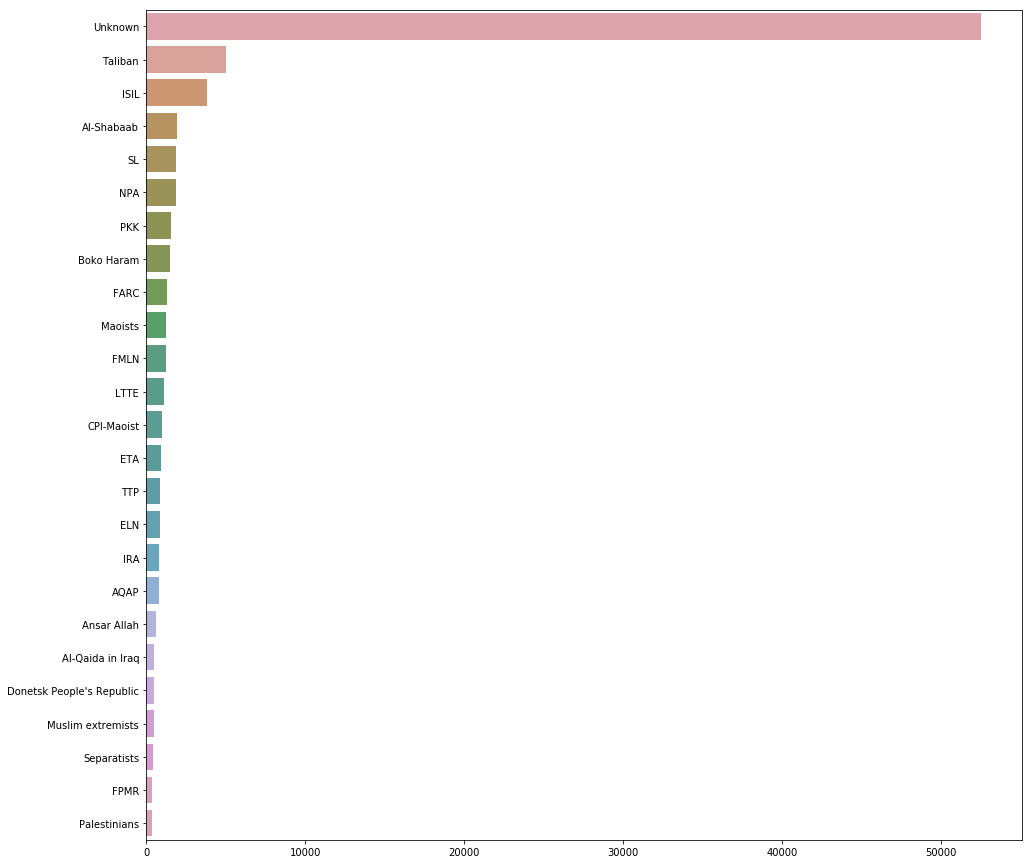

In [21]:
a4_dims=(15.7,15.27)
fig,ax=plt.subplots()
fig.set_size_inches(a4_dims)
sns.barplot(y,x,saturation=.5,dodge=False)

Here we can see the distribution of the gname classes.Even though **"Unkown"** category is dominating,we can change this perspective

In [22]:
df2["gname"]=df2["gname"].str.replace("'",' ')
greater_group_values=df2['gname'].value_counts()

In [23]:
print("Total count of all the classes present before filtering ",sum(Counter(df2.gname.values).values()))
print("Total count of all the classes after filtering where we take minimum occurence of a class more than 150 times is ",
      len(Counter(df2.loc[df2["gname"].isin(greater_group_values[greater_group_values>150].index)].gname).values()))

Total count of all the classes present before filtering  106564
Total count of all the classes after filtering where we take minimum occurence of a class more than 150 times is  56


Thus we will filter out the classes,and now allocate them to different new dataframe

In [24]:
groups2=greater_group_values[greater_group_values>150]
groups2

Unknown                                                        52491
Taliban                                                         5029
Islamic State of Iraq and the Levant (ISIL)                     3823
Al-Shabaab                                                      1951
Shining Path (SL)                                               1900
New People s Army (NPA)                                         1870
Kurdistan Workers  Party (PKK)                                  1549
Boko Haram                                                      1507
Revolutionary Armed Forces of Colombia (FARC)                   1283
Maoists                                                         1253
Farabundo Marti National Liberation Front (FMLN)                1215
Liberation Tigers of Tamil Eelam (LTTE)                         1098
Communist Party of India - Maoist (CPI-Maoist)                  1021
Basque Fatherland and Freedom (ETA)                              926
Tehrik-i-Taliban Pakistan (TTP)   

In [25]:
df3=df2.loc[df2["gname"].isin(groups2.index)]

Convert text data to label format

We encode the labels present in the gname,with the labelEncoder value provided by the sklearn.When certain values are not present in the encoder or the label.We will be also do the same transformation with the city and provstate

####  provstate
    The variable records the name (at the time of event) of the 1st order subnational administrative region in which the event occurs. 
    
#### City
    This field contains the name of the city, village, or town in which the incident  occurred
Both these values are important,as we can assume that some of the cities infulences the attackers to attack
The label enocder values works if there are any hashable or comparable values,then a particular value is added to it.

In [26]:
labelencoder = LabelEncoder()
df3["y"]=labelencoder.fit_transform(df3['gname'])
df3["ncity"]=labelencoder.fit_transform(df3['city'])
df3['nprovstate'] = labelencoder.fit_transform(df3['provstate'])

In [27]:
df4=df3.drop(['city','provstate',"gname"],axis=1)
col=['iyear', 'imonth', 'iday', 'extended', 'country', 'region', 'latitude',
       'longitude', 'success', 'suicide', 'attacktype1', 'targtype1',
       'natlty1', 'weaptype1', 'nkill', 'multiple', 'individual', 'property',
       'natlty1', 'ncity', 'nprovstate','y']
df4=df4[col]

In [28]:
df4

,iyear,imonth,iday,extended,country,region,latitude,longitude,success,suicide,...,weaptype1,nkill,multiple,individual,property,natlty1,natlty1,ncity,nprovstate,y
7,1970,1,2,0,217,1,37.791927,-122.225906,1,0,...,6,0.0,0.0,0,1,217.0,217.0,14518,350,55
11,1970,1,6,0,217,1,39.758968,-104.876305,1,0,...,8,0.0,0.0,0,1,217.0,217.0,5435,452,28
12,1970,1,8,0,98,8,41.890961,12.490069,1,0,...,5,0.0,0.0,0,0,217.0,217.0,16655,1029,55
13,1970,1,9,0,217,1,42.331685,-83.047924,1,0,...,8,0.0,0.0,0,1,217.0,217.0,5480,1176,28
33,1970,1,27,0,217,1,41.241996,-82.615241,1,0,...,8,0.0,0.0,0,1,217.0,217.0,14385,1393,28
40,1970,1,31,0,217,1,39.758968,-104.876305,1,0,...,6,0.0,0.0,0,1,217.0,217.0,5435,452,55
41,1970,2,1,0,217,1,45.511795,-122.675629,1,0,...,8,0.0,0.0,0,1,217.0,217.0,15731,1410,28
43,1970,2,2,0,217,1,40.697132,-73.931351,0,0,...,8,0.0,0.0,0,0,217.0,217.0,14210,1302,55
44,1970,2,3,0,217,1,40.697132,-73.931351,0,0,...,8,0.0,1.0,0,0,217.0,217.0,14210,1302,55
45,1970,2,3,0,217,1,40.697132,-73.931351,0,0,...,8,0.0,1.0,0,0,217.0,217.0,14210,1302,55


In [29]:
X = df4.iloc[:, 0:20].values
y = df4.iloc[:, -1].values

All the Features are taken as ***X*** and the last value,which is the label(our labeled group name ) is taken as ***Y***


There might be still missing values present after the transformation in X values,we will replace those values by the mean of that 

In [30]:
X_train, X_test , y_train , y_test = train_test_split(X, y , test_size=0.4, random_state = 0)

Using Bayesian Optimization,we see the optimal parameters in the Random Forest.

In [15]:
scoring = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'rec_micro': 'recall_macro'}

from bayes_opt import BayesianOptimization
from sklearn.cross_validation import cross_val_score
def rfccv(n_estimators, min_samples_split, max_features,max_leaf_nodes):
    classifier= RFC(n_estimators=int(n_estimators),
            min_samples_split=int(min_samples_split),
            max_features=min(max_features, 0.999),
            random_state=2,max_leaf_nodes= int(max_leaf_nodes),verbose=2,n_jobs=-1)
    classifier.fit( X_train,y_train)
    accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10, scoring = 'accuracy')
         
    return accuracies.mean()



gp_params = {"alpha": 1e-5}

rfcBO = BayesianOptimization(
        rfccv,
        {'n_estimators': (70, 80),
        'min_samples_split': (14, 16),
        'max_features': (0.7, 0.899),
        'max_leaf_nodes':(10000,15000)}
    )
rfcBO.maximize(n_iter=9, **gp_params)

Initialization
--------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   max_features |   max_leaf_nodes |   min_samples_split |   n_estimators | 
building tree 1 of 79
building tree 2 of 79
building tree 3 of 79
building tree 4 of 79
building tree 5 of 79
building tree 6 of 79
building tree 7 of 79
building tree 8 of 79
building tree 9 of 79
building tree 10 of 79
building tree 11 of 79
building tree 12 of 79
building tree 13 of 79
building tree 14 of 79
building tree 15 of 79
building tree 16 of 79
building tree 17 of 79
building tree 18 of 79
building tree 19 of 79
building tree 20 of 79
building tree 21 of 79
building tree 22 of 79
building tree 23 of 79
building tree 24 of 79
building tree 25 of 79
building tree 26 of 79
building tree 27 of 79
building tree 28 of 79
building tree 29 of 79
building tree 30 of 79
building tree 31 of 79
building tree 32 of 79
building tree 33 of 79
building tree 34 of 79
b

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.0s


building tree 40 of 79building tree 39 of 79

building tree 41 of 79
building tree 42 of 79
building tree 43 of 79
building tree 44 of 79
building tree 45 of 79
building tree 46 of 79
building tree 47 of 79
building tree 48 of 79
building tree 49 of 79building tree 50 of 79

building tree 51 of 79
building tree 52 of 79
building tree 53 of 79
building tree 54 of 79
building tree 55 of 79
building tree 56 of 79
building tree 57 of 79
building tree 58 of 79
building tree 59 of 79
building tree 60 of 79
building tree 61 of 79
building tree 62 of 79
building tree 63 of 79
building tree 64 of 79
building tree 65 of 79
building tree 66 of 79
building tree 67 of 79
building tree 68 of 79
building tree 69 of 79
building tree 70 of 79
building tree 71 of 79
building tree 72 of 79
building tree 73 of 79
building tree 74 of 79
building tree 75 of 79
building tree 76 of 79
building tree 77 of 79
building tree 78 of 79
building tree 79 of 79


[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   18.9s finished


building tree 1 of 79
building tree 2 of 79
building tree 3 of 79
building tree 4 of 79
building tree 5 of 79
building tree 6 of 79
building tree 7 of 79
building tree 8 of 79
building tree 9 of 79
building tree 10 of 79
building tree 11 of 79
building tree 12 of 79
building tree 13 of 79
building tree 14 of 79
building tree 15 of 79
building tree 16 of 79
building tree 17 of 79
building tree 18 of 79
building tree 19 of 79
building tree 20 of 79
building tree 21 of 79
building tree 22 of 79
building tree 23 of 79
building tree 24 of 79
building tree 25 of 79
building tree 26 of 79
building tree 27 of 79
building tree 28 of 79
building tree 29 of 79
building tree 30 of 79
building tree 31 of 79
building tree 32 of 79
building tree 33 of 79
building tree 34 of 79
building tree 35 of 79
building tree 36 of 79
building tree 37 of 79
building tree 38 of 79


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.1s


building tree 39 of 79
building tree 40 of 79
building tree 41 of 79
building tree 42 of 79
building tree 43 of 79
building tree 44 of 79
building tree 45 of 79
building tree 46 of 79
building tree 47 of 79
building tree 48 of 79
building tree 49 of 79
building tree 50 of 79
building tree 51 of 79
building tree 52 of 79
building tree 53 of 79
building tree 54 of 79
building tree 55 of 79
building tree 56 of 79
building tree 57 of 79
building tree 58 of 79
building tree 59 of 79
building tree 60 of 79
building tree 61 of 79
building tree 62 of 79
building tree 63 of 79
building tree 64 of 79
building tree 65 of 79
building tree 66 of 79
building tree 67 of 79
building tree 68 of 79
building tree 69 of 79building tree 70 of 79

building tree 71 of 79
building tree 72 of 79
building tree 73 of 79
building tree 74 of 79
building tree 75 of 79
building tree 76 of 79
building tree 77 of 79
building tree 78 of 79
building tree 79 of 79


[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   17.0s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  79 out of  79 | elapsed:    0.2s finished


building tree 1 of 79
building tree 2 of 79
building tree 3 of 79
building tree 4 of 79
building tree 5 of 79
building tree 6 of 79
building tree 7 of 79
building tree 8 of 79
building tree 9 of 79
building tree 10 of 79
building tree 11 of 79
building tree 12 of 79
building tree 13 of 79
building tree 14 of 79
building tree 15 of 79
building tree 16 of 79
building tree 17 of 79
building tree 18 of 79
building tree 19 of 79
building tree 20 of 79
building tree 21 of 79
building tree 22 of 79
building tree 23 of 79
building tree 24 of 79
building tree 25 of 79
building tree 26 of 79
building tree 27 of 79
building tree 28 of 79
building tree 29 of 79
building tree 30 of 79
building tree 31 of 79
building tree 32 of 79
building tree 33 of 79
building tree 34 of 79
building tree 35 of 79
building tree 36 of 79
building tree 37 of 79
building tree 38 of 79
building tree 39 of 79


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.1s


building tree 40 of 79
building tree 41 of 79
building tree 42 of 79
building tree 43 of 79
building tree 44 of 79
building tree 45 of 79
building tree 46 of 79
building tree 47 of 79
building tree 48 of 79
building tree 49 of 79
building tree 50 of 79
building tree 51 of 79
building tree 52 of 79
building tree 53 of 79
building tree 54 of 79
building tree 55 of 79
building tree 56 of 79
building tree 57 of 79
building tree 58 of 79
building tree 59 of 79
building tree 60 of 79
building tree 61 of 79
building tree 62 of 79
building tree 63 of 79
building tree 64 of 79
building tree 65 of 79
building tree 66 of 79
building tree 67 of 79
building tree 68 of 79
building tree 69 of 79
building tree 70 of 79
building tree 71 of 79
building tree 72 of 79
building tree 73 of 79
building tree 74 of 79
building tree 75 of 79
building tree 76 of 79
building tree 77 of 79
building tree 78 of 79
building tree 79 of 79


[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   16.9s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  79 out of  79 | elapsed:    0.2s finished


building tree 1 of 79
building tree 2 of 79
building tree 3 of 79
building tree 4 of 79
building tree 5 of 79
building tree 6 of 79
building tree 7 of 79
building tree 8 of 79
building tree 9 of 79
building tree 10 of 79
building tree 11 of 79
building tree 12 of 79
building tree 13 of 79
building tree 14 of 79
building tree 15 of 79
building tree 16 of 79
building tree 17 of 79
building tree 18 of 79
building tree 19 of 79
building tree 20 of 79
building tree 21 of 79
building tree 22 of 79
building tree 23 of 79
building tree 24 of 79
building tree 25 of 79
building tree 26 of 79
building tree 27 of 79
building tree 28 of 79
building tree 29 of 79
building tree 30 of 79
building tree 31 of 79
building tree 32 of 79
building tree 33 of 79
building tree 34 of 79
building tree 35 of 79
building tree 36 of 79
building tree 37 of 79
building tree 38 of 79


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.1s


building tree 39 of 79
building tree 40 of 79
building tree 41 of 79
building tree 42 of 79
building tree 43 of 79
building tree 44 of 79
building tree 45 of 79
building tree 46 of 79
building tree 47 of 79
building tree 48 of 79
building tree 49 of 79
building tree 50 of 79
building tree 51 of 79
building tree 52 of 79
building tree 53 of 79
building tree 54 of 79
building tree 55 of 79
building tree 56 of 79
building tree 57 of 79
building tree 58 of 79
building tree 59 of 79
building tree 60 of 79
building tree 61 of 79
building tree 62 of 79
building tree 63 of 79
building tree 64 of 79
building tree 65 of 79
building tree 66 of 79
building tree 67 of 79
building tree 68 of 79
building tree 69 of 79
building tree 70 of 79
building tree 71 of 79
building tree 72 of 79
building tree 73 of 79
building tree 74 of 79
building tree 75 of 79
building tree 76 of 79
building tree 77 of 79
building tree 78 of 79
building tree 79 of 79


[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   16.9s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  79 out of  79 | elapsed:    0.2s finished


building tree 1 of 79building tree 2 of 79

building tree 3 of 79
building tree 4 of 79
building tree 5 of 79
building tree 6 of 79
building tree 7 of 79
building tree 8 of 79
building tree 9 of 79
building tree 10 of 79
building tree 11 of 79
building tree 12 of 79
building tree 13 of 79
building tree 14 of 79
building tree 15 of 79
building tree 16 of 79
building tree 17 of 79
building tree 18 of 79
building tree 19 of 79
building tree 20 of 79
building tree 21 of 79
building tree 22 of 79
building tree 23 of 79
building tree 24 of 79
building tree 25 of 79
building tree 26 of 79
building tree 27 of 79
building tree 28 of 79
building tree 29 of 79
building tree 30 of 79
building tree 31 of 79
building tree 32 of 79
building tree 33 of 79
building tree 34 of 79
building tree 35 of 79
building tree 36 of 79
building tree 37 of 79
building tree 38 of 79


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.1s


building tree 39 of 79
building tree 40 of 79
building tree 41 of 79
building tree 42 of 79
building tree 43 of 79
building tree 44 of 79
building tree 45 of 79
building tree 46 of 79
building tree 47 of 79
building tree 48 of 79
building tree 49 of 79
building tree 50 of 79
building tree 51 of 79
building tree 52 of 79
building tree 53 of 79
building tree 54 of 79
building tree 55 of 79
building tree 56 of 79
building tree 57 of 79
building tree 58 of 79
building tree 59 of 79
building tree 60 of 79
building tree 61 of 79
building tree 62 of 79
building tree 63 of 79
building tree 64 of 79
building tree 65 of 79
building tree 66 of 79
building tree 67 of 79
building tree 68 of 79
building tree 69 of 79
building tree 70 of 79
building tree 71 of 79
building tree 72 of 79
building tree 73 of 79
building tree 74 of 79
building tree 75 of 79
building tree 76 of 79
building tree 77 of 79
building tree 78 of 79
building tree 79 of 79


[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   16.9s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  79 out of  79 | elapsed:    0.2s finished


building tree 1 of 79
building tree 2 of 79
building tree 3 of 79
building tree 4 of 79
building tree 5 of 79
building tree 6 of 79
building tree 7 of 79
building tree 8 of 79
building tree 9 of 79
building tree 10 of 79
building tree 11 of 79
building tree 12 of 79
building tree 13 of 79
building tree 14 of 79
building tree 15 of 79
building tree 16 of 79
building tree 17 of 79
building tree 18 of 79
building tree 19 of 79
building tree 20 of 79
building tree 21 of 79
building tree 22 of 79
building tree 23 of 79
building tree 24 of 79
building tree 25 of 79
building tree 26 of 79
building tree 27 of 79
building tree 28 of 79
building tree 29 of 79
building tree 30 of 79
building tree 31 of 79
building tree 32 of 79
building tree 33 of 79
building tree 34 of 79
building tree 35 of 79
building tree 36 of 79
building tree 37 of 79
building tree 38 of 79


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.0s


building tree 39 of 79
building tree 40 of 79
building tree 41 of 79
building tree 42 of 79
building tree 43 of 79
building tree 44 of 79
building tree 45 of 79
building tree 46 of 79
building tree 47 of 79
building tree 48 of 79
building tree 49 of 79
building tree 50 of 79
building tree 51 of 79
building tree 52 of 79
building tree 53 of 79
building tree 54 of 79
building tree 55 of 79
building tree 56 of 79
building tree 57 of 79
building tree 58 of 79
building tree 59 of 79
building tree 60 of 79
building tree 61 of 79
building tree 62 of 79
building tree 63 of 79
building tree 64 of 79
building tree 65 of 79
building tree 66 of 79
building tree 67 of 79
building tree 68 of 79
building tree 69 of 79
building tree 70 of 79
building tree 71 of 79
building tree 72 of 79
building tree 73 of 79
building tree 74 of 79
building tree 75 of 79
building tree 76 of 79
building tree 77 of 79
building tree 78 of 79
building tree 79 of 79


[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   16.9s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  79 out of  79 | elapsed:    0.2s finished


building tree 1 of 79
building tree 2 of 79
building tree 3 of 79
building tree 4 of 79
building tree 5 of 79
building tree 6 of 79
building tree 7 of 79
building tree 8 of 79
building tree 9 of 79
building tree 10 of 79
building tree 11 of 79
building tree 12 of 79
building tree 13 of 79
building tree 14 of 79
building tree 15 of 79
building tree 16 of 79
building tree 17 of 79
building tree 18 of 79
building tree 19 of 79
building tree 20 of 79
building tree 21 of 79
building tree 22 of 79
building tree 23 of 79
building tree 24 of 79
building tree 25 of 79
building tree 26 of 79
building tree 27 of 79
building tree 28 of 79
building tree 29 of 79
building tree 30 of 79
building tree 31 of 79
building tree 32 of 79
building tree 33 of 79
building tree 34 of 79
building tree 35 of 79
building tree 36 of 79
building tree 37 of 79
building tree 38 of 79
building tree 39 of 79


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.9s


building tree 40 of 79
building tree 41 of 79
building tree 42 of 79
building tree 43 of 79
building tree 44 of 79
building tree 45 of 79
building tree 46 of 79
building tree 47 of 79
building tree 48 of 79
building tree 49 of 79
building tree 50 of 79
building tree 51 of 79
building tree 52 of 79
building tree 53 of 79
building tree 54 of 79
building tree 55 of 79
building tree 56 of 79
building tree 57 of 79
building tree 58 of 79
building tree 59 of 79
building tree 60 of 79
building tree 61 of 79
building tree 62 of 79
building tree 63 of 79
building tree 64 of 79
building tree 65 of 79
building tree 66 of 79
building tree 67 of 79
building tree 68 of 79
building tree 69 of 79
building tree 70 of 79
building tree 71 of 79
building tree 72 of 79
building tree 73 of 79
building tree 74 of 79
building tree 75 of 79
building tree 76 of 79
building tree 77 of 79
building tree 78 of 79
building tree 79 of 79


[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   16.8s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  79 out of  79 | elapsed:    0.2s finished


building tree 1 of 79
building tree 2 of 79
building tree 3 of 79
building tree 4 of 79
building tree 5 of 79
building tree 6 of 79
building tree 7 of 79
building tree 8 of 79
building tree 9 of 79
building tree 10 of 79
building tree 11 of 79
building tree 12 of 79
building tree 13 of 79
building tree 14 of 79
building tree 15 of 79
building tree 16 of 79
building tree 17 of 79
building tree 18 of 79
building tree 19 of 79
building tree 20 of 79
building tree 21 of 79
building tree 22 of 79
building tree 23 of 79
building tree 24 of 79
building tree 25 of 79
building tree 26 of 79
building tree 27 of 79
building tree 28 of 79
building tree 29 of 79
building tree 30 of 79
building tree 31 of 79
building tree 32 of 79
building tree 33 of 79
building tree 34 of 79
building tree 35 of 79
building tree 36 of 79
building tree 37 of 79
building tree 38 of 79


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.1s


building tree 39 of 79
building tree 40 of 79
building tree 41 of 79
building tree 42 of 79
building tree 43 of 79
building tree 44 of 79
building tree 45 of 79
building tree 46 of 79
building tree 47 of 79
building tree 48 of 79
building tree 49 of 79
building tree 50 of 79
building tree 51 of 79
building tree 52 of 79
building tree 53 of 79
building tree 54 of 79
building tree 55 of 79
building tree 56 of 79
building tree 57 of 79
building tree 58 of 79
building tree 59 of 79
building tree 60 of 79
building tree 61 of 79
building tree 62 of 79
building tree 63 of 79
building tree 64 of 79
building tree 65 of 79
building tree 66 of 79
building tree 67 of 79
building tree 68 of 79
building tree 69 of 79
building tree 70 of 79
building tree 71 of 79
building tree 72 of 79
building tree 73 of 79
building tree 74 of 79
building tree 75 of 79
building tree 76 of 79
building tree 77 of 79
building tree 78 of 79
building tree 79 of 79


[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   16.9s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  79 out of  79 | elapsed:    0.2s finished


building tree 1 of 79
building tree 2 of 79
building tree 3 of 79
building tree 4 of 79
building tree 5 of 79
building tree 6 of 79
building tree 7 of 79
building tree 8 of 79
building tree 9 of 79
building tree 10 of 79
building tree 11 of 79
building tree 12 of 79
building tree 13 of 79
building tree 14 of 79
building tree 15 of 79
building tree 16 of 79
building tree 17 of 79
building tree 18 of 79
building tree 19 of 79
building tree 20 of 79
building tree 21 of 79
building tree 22 of 79
building tree 23 of 79
building tree 24 of 79
building tree 25 of 79
building tree 26 of 79
building tree 27 of 79
building tree 28 of 79
building tree 29 of 79
building tree 30 of 79
building tree 31 of 79
building tree 32 of 79
building tree 33 of 79
building tree 34 of 79
building tree 35 of 79
building tree 36 of 79
building tree 37 of 79
building tree 38 of 79


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.2s


building tree 39 of 79
building tree 40 of 79
building tree 41 of 79
building tree 42 of 79
building tree 43 of 79
building tree 44 of 79
building tree 45 of 79
building tree 46 of 79
building tree 47 of 79
building tree 48 of 79
building tree 49 of 79
building tree 50 of 79
building tree 51 of 79
building tree 52 of 79
building tree 53 of 79
building tree 54 of 79
building tree 55 of 79
building tree 56 of 79
building tree 57 of 79
building tree 58 of 79
building tree 59 of 79
building tree 60 of 79
building tree 61 of 79
building tree 62 of 79
building tree 63 of 79
building tree 64 of 79
building tree 65 of 79
building tree 66 of 79
building tree 67 of 79
building tree 68 of 79
building tree 69 of 79
building tree 70 of 79
building tree 71 of 79
building tree 72 of 79
building tree 73 of 79
building tree 74 of 79
building tree 75 of 79
building tree 76 of 79
building tree 77 of 79
building tree 78 of 79
building tree 79 of 79


[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   17.0s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  79 out of  79 | elapsed:    0.2s finished


building tree 1 of 79
building tree 2 of 79
building tree 3 of 79
building tree 4 of 79
building tree 5 of 79
building tree 6 of 79
building tree 7 of 79
building tree 8 of 79
building tree 9 of 79
building tree 10 of 79
building tree 11 of 79
building tree 12 of 79
building tree 13 of 79
building tree 14 of 79
building tree 15 of 79
building tree 16 of 79
building tree 17 of 79
building tree 18 of 79
building tree 19 of 79
building tree 20 of 79
building tree 21 of 79
building tree 22 of 79
building tree 23 of 79
building tree 24 of 79
building tree 25 of 79
building tree 26 of 79
building tree 27 of 79
building tree 28 of 79
building tree 29 of 79
building tree 30 of 79
building tree 31 of 79
building tree 32 of 79
building tree 33 of 79
building tree 34 of 79
building tree 35 of 79
building tree 36 of 79
building tree 37 of 79
building tree 38 of 79


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.1s


building tree 39 of 79
building tree 40 of 79
building tree 41 of 79
building tree 42 of 79
building tree 43 of 79
building tree 44 of 79
building tree 45 of 79
building tree 46 of 79
building tree 47 of 79
building tree 48 of 79
building tree 49 of 79
building tree 50 of 79
building tree 51 of 79
building tree 52 of 79
building tree 53 of 79
building tree 54 of 79
building tree 55 of 79
building tree 56 of 79
building tree 57 of 79
building tree 58 of 79
building tree 59 of 79
building tree 60 of 79
building tree 61 of 79
building tree 62 of 79
building tree 63 of 79
building tree 64 of 79
building tree 65 of 79
building tree 66 of 79
building tree 67 of 79
building tree 68 of 79
building tree 69 of 79
building tree 70 of 79
building tree 71 of 79
building tree 72 of 79
building tree 73 of 79
building tree 74 of 79
building tree 75 of 79
building tree 76 of 79
building tree 77 of 79
building tree 78 of 79
building tree 79 of 79


[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   16.9s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  79 out of  79 | elapsed:    0.2s finished


building tree 1 of 79building tree 2 of 79

building tree 3 of 79
building tree 4 of 79
building tree 5 of 79
building tree 6 of 79
building tree 7 of 79
building tree 8 of 79
building tree 9 of 79
building tree 10 of 79
building tree 11 of 79
building tree 12 of 79
building tree 13 of 79
building tree 14 of 79
building tree 15 of 79
building tree 16 of 79
building tree 17 of 79
building tree 18 of 79
building tree 19 of 79
building tree 20 of 79
building tree 21 of 79
building tree 22 of 79
building tree 23 of 79
building tree 24 of 79
building tree 25 of 79
building tree 26 of 79
building tree 27 of 79
building tree 28 of 79
building tree 29 of 79
building tree 30 of 79
building tree 31 of 79
building tree 32 of 79
building tree 33 of 79
building tree 34 of 79
building tree 35 of 79
building tree 36 of 79
building tree 37 of 79
building tree 38 of 79


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.2s


building tree 39 of 79
building tree 40 of 79
building tree 41 of 79
building tree 42 of 79
building tree 43 of 79
building tree 44 of 79
building tree 45 of 79
building tree 46 of 79
building tree 47 of 79
building tree 48 of 79
building tree 49 of 79
building tree 50 of 79
building tree 51 of 79
building tree 52 of 79
building tree 53 of 79
building tree 54 of 79
building tree 55 of 79
building tree 56 of 79
building tree 57 of 79
building tree 58 of 79
building tree 59 of 79
building tree 60 of 79
building tree 61 of 79
building tree 62 of 79
building tree 63 of 79
building tree 64 of 79
building tree 65 of 79
building tree 66 of 79
building tree 67 of 79
building tree 68 of 79
building tree 69 of 79
building tree 70 of 79
building tree 71 of 79
building tree 72 of 79
building tree 73 of 79
building tree 74 of 79
building tree 75 of 79
building tree 76 of 79
building tree 77 of 79
building tree 78 of 79
building tree 79 of 79


[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   17.0s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  79 out of  79 | elapsed:    0.2s finished


    1 | 03m11s |    0.82935 |         0.8608 |       13291.0515 |             14.2068 |        79.5290 | 
building tree 2 of 74building tree 1 of 74

building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.0s


building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tree 59 of 74
building tree 60 of 74
building tree 61 of 74
building tree 62 of 74
building tree 63 of 74
building tree 64 of 74
building tree 65 of 74
building tree 66 of 74
building tree 67 of 74
building tree 68 of 74
building tree 69 of 74
building tree 70 of 74
building tree 71 of 74
building tree 72 of 74
building tree 73 of 74
building tree 74 of 74


[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:   17.6s finished


building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.0s


building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tree 59 of 74
building tree 60 of 74
building tree 61 of 74
building tree 62 of 74
building tree 63 of 74
building tree 64 of 74
building tree 65 of 74
building tree 66 of 74
building tree 67 of 74
building tree 68 of 74
building tree 69 of 74
building tree 70 of 74
building tree 71 of 74
building tree 72 of 74
building tree 73 of 74
building tree 74 of 74


[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:   15.8s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  74 out of  74 | elapsed:    0.2s finished


building tree 1 of 74building tree 2 of 74

building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.0s


building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tree 59 of 74
building tree 60 of 74
building tree 61 of 74
building tree 62 of 74
building tree 63 of 74
building tree 64 of 74
building tree 65 of 74
building tree 66 of 74
building tree 67 of 74
building tree 68 of 74
building tree 69 of 74
building tree 70 of 74
building tree 71 of 74
building tree 72 of 74
building tree 73 of 74
building tree 74 of 74


[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:   15.6s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  74 out of  74 | elapsed:    0.2s finished


building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.1s


building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tree 59 of 74
building tree 60 of 74
building tree 61 of 74
building tree 62 of 74
building tree 63 of 74
building tree 64 of 74
building tree 65 of 74
building tree 66 of 74
building tree 67 of 74
building tree 68 of 74
building tree 69 of 74
building tree 70 of 74
building tree 71 of 74
building tree 72 of 74
building tree 73 of 74
building tree 74 of 74


[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:   15.6s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  74 out of  74 | elapsed:    0.2s finished


building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.1s


building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tree 59 of 74
building tree 60 of 74
building tree 61 of 74
building tree 62 of 74
building tree 63 of 74
building tree 64 of 74
building tree 65 of 74building tree 66 of 74

building tree 67 of 74
building tree 68 of 74
building tree 69 of 74
building tree 70 of 74
building tree 71 of 74
building tree 72 of 74
building tree 73 of 74
building tree 74 of 74


[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:   15.7s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  74 out of  74 | elapsed:    0.2s finished


building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.0s


building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tree 59 of 74
building tree 60 of 74
building tree 61 of 74
building tree 62 of 74
building tree 63 of 74
building tree 64 of 74
building tree 65 of 74
building tree 66 of 74
building tree 67 of 74
building tree 68 of 74
building tree 69 of 74
building tree 70 of 74
building tree 71 of 74
building tree 72 of 74
building tree 73 of 74
building tree 74 of 74


[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:   15.7s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  74 out of  74 | elapsed:    0.2s finished


building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.0s


building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tree 59 of 74
building tree 60 of 74
building tree 61 of 74
building tree 62 of 74
building tree 63 of 74
building tree 64 of 74
building tree 65 of 74
building tree 66 of 74
building tree 67 of 74
building tree 68 of 74
building tree 69 of 74
building tree 70 of 74
building tree 71 of 74
building tree 72 of 74
building tree 73 of 74
building tree 74 of 74


[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:   15.6s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  74 out of  74 | elapsed:    0.2s finished


building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.0s


building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tree 59 of 74
building tree 60 of 74
building tree 61 of 74
building tree 62 of 74
building tree 63 of 74
building tree 64 of 74
building tree 65 of 74
building tree 66 of 74
building tree 67 of 74
building tree 68 of 74
building tree 69 of 74
building tree 70 of 74
building tree 71 of 74
building tree 72 of 74
building tree 73 of 74
building tree 74 of 74


[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:   15.6s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  74 out of  74 | elapsed:    0.2s finished


building tree 1 of 74building tree 2 of 74

building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.0s


building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tree 59 of 74
building tree 60 of 74
building tree 61 of 74
building tree 62 of 74
building tree 63 of 74
building tree 64 of 74
building tree 65 of 74
building tree 66 of 74
building tree 67 of 74
building tree 68 of 74
building tree 69 of 74
building tree 70 of 74
building tree 71 of 74
building tree 72 of 74
building tree 73 of 74
building tree 74 of 74


[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:   15.7s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  74 out of  74 | elapsed:    0.2s finished


building tree 2 of 74
building tree 1 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.0s


building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tree 59 of 74
building tree 60 of 74
building tree 61 of 74
building tree 62 of 74
building tree 63 of 74
building tree 64 of 74
building tree 65 of 74
building tree 66 of 74
building tree 67 of 74
building tree 68 of 74
building tree 69 of 74
building tree 70 of 74
building tree 71 of 74
building tree 72 of 74
building tree 73 of 74
building tree 74 of 74


[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:   15.8s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  74 out of  74 | elapsed:    0.2s finished


building tree 1 of 74building tree 2 of 74

building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.9s


building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 74
building tree 45 of 74
building tree 46 of 74
building tree 47 of 74
building tree 48 of 74
building tree 49 of 74
building tree 50 of 74
building tree 51 of 74
building tree 52 of 74
building tree 53 of 74
building tree 54 of 74
building tree 55 of 74
building tree 56 of 74
building tree 57 of 74
building tree 58 of 74
building tree 59 of 74
building tree 60 of 74
building tree 61 of 74
building tree 62 of 74
building tree 63 of 74building tree 64 of 74

building tree 65 of 74
building tree 66 of 74
building tree 67 of 74
building tree 68 of 74
building tree 69 of 74
building tree 70 of 74
building tree 71 of 74
building tree 72 of 74
building tree 73 of 74
building tree 74 of 74


[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:   15.6s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  74 out of  74 | elapsed:    0.2s finished


    2 | 02m57s |    0.82920 |         0.8738 |       12870.6002 |             15.0944 |        74.6886 | 
building tree 1 of 71
building tree 2 of 71
building tree 3 of 71
building tree 4 of 71
building tree 5 of 71
building tree 6 of 71
building tree 7 of 71
building tree 8 of 71
building tree 9 of 71
building tree 10 of 71
building tree 11 of 71
building tree 12 of 71
building tree 13 of 71
building tree 14 of 71
building tree 15 of 71
building tree 16 of 71
building tree 17 of 71
building tree 18 of 71
building tree 19 of 71
building tree 20 of 71
building tree 21 of 71
building tree 22 of 71
building tree 23 of 71
building tree 24 of 71
building tree 25 of 71
building tree 26 of 71
building tree 27 of 71
building tree 28 of 71
building tree 29 of 71
building tree 30 of 71
building tree 31 of 71
building tree 32 of 71
building tree 33 of 71
building tree 34 of 71
building tree 35 of 71
building tree 36 of 71
building tree 37 of 71
building tree 38 of 71
building tree 39 of 71


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.9s


building tree 40 of 71
building tree 41 of 71
building tree 42 of 71
building tree 43 of 71
building tree 44 of 71
building tree 45 of 71
building tree 46 of 71
building tree 47 of 71
building tree 48 of 71
building tree 49 of 71
building tree 50 of 71
building tree 51 of 71
building tree 52 of 71
building tree 53 of 71
building tree 54 of 71
building tree 55 of 71
building tree 56 of 71
building tree 57 of 71
building tree 58 of 71
building tree 59 of 71
building tree 60 of 71
building tree 61 of 71
building tree 62 of 71
building tree 63 of 71
building tree 64 of 71
building tree 65 of 71
building tree 66 of 71
building tree 67 of 71
building tree 68 of 71
building tree 69 of 71
building tree 70 of 71
building tree 71 of 71


[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:   17.0s finished


building tree 1 of 71
building tree 2 of 71
building tree 3 of 71building tree 4 of 71

building tree 5 of 71
building tree 6 of 71
building tree 7 of 71
building tree 8 of 71
building tree 9 of 71
building tree 10 of 71
building tree 11 of 71
building tree 12 of 71
building tree 13 of 71
building tree 14 of 71
building tree 15 of 71
building tree 16 of 71
building tree 17 of 71
building tree 18 of 71
building tree 19 of 71
building tree 20 of 71
building tree 21 of 71
building tree 22 of 71
building tree 23 of 71
building tree 24 of 71
building tree 25 of 71
building tree 26 of 71
building tree 27 of 71
building tree 28 of 71
building tree 29 of 71
building tree 30 of 71
building tree 31 of 71
building tree 32 of 71
building tree 33 of 71
building tree 34 of 71
building tree 35 of 71
building tree 36 of 71
building tree 37 of 71
building tree 38 of 71


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.1s


building tree 39 of 71
building tree 40 of 71
building tree 41 of 71
building tree 42 of 71
building tree 43 of 71
building tree 44 of 71
building tree 45 of 71
building tree 46 of 71
building tree 47 of 71
building tree 48 of 71
building tree 49 of 71
building tree 50 of 71
building tree 51 of 71
building tree 52 of 71
building tree 53 of 71
building tree 54 of 71
building tree 55 of 71
building tree 56 of 71
building tree 57 of 71
building tree 58 of 71
building tree 59 of 71
building tree 60 of 71
building tree 61 of 71
building tree 62 of 71
building tree 63 of 71
building tree 64 of 71
building tree 65 of 71
building tree 66 of 71
building tree 67 of 71
building tree 68 of 71
building tree 69 of 71
building tree 70 of 71
building tree 71 of 71


[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:   15.1s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  71 out of  71 | elapsed:    0.2s finished


building tree 1 of 71
building tree 2 of 71
building tree 3 of 71
building tree 4 of 71
building tree 5 of 71
building tree 6 of 71
building tree 7 of 71
building tree 8 of 71
building tree 9 of 71
building tree 10 of 71
building tree 11 of 71
building tree 12 of 71
building tree 13 of 71
building tree 14 of 71
building tree 15 of 71
building tree 16 of 71
building tree 17 of 71
building tree 18 of 71
building tree 19 of 71
building tree 20 of 71
building tree 21 of 71
building tree 22 of 71
building tree 23 of 71
building tree 24 of 71
building tree 25 of 71
building tree 26 of 71
building tree 27 of 71
building tree 28 of 71
building tree 29 of 71
building tree 30 of 71
building tree 31 of 71
building tree 32 of 71
building tree 33 of 71
building tree 34 of 71
building tree 35 of 71
building tree 36 of 71
building tree 37 of 71
building tree 38 of 71


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.1s


building tree 39 of 71
building tree 40 of 71
building tree 41 of 71
building tree 42 of 71
building tree 43 of 71
building tree 44 of 71
building tree 45 of 71
building tree 46 of 71
building tree 47 of 71
building tree 48 of 71
building tree 49 of 71
building tree 50 of 71
building tree 51 of 71
building tree 52 of 71
building tree 53 of 71
building tree 54 of 71
building tree 55 of 71
building tree 56 of 71
building tree 57 of 71
building tree 58 of 71
building tree 59 of 71
building tree 60 of 71
building tree 61 of 71
building tree 62 of 71
building tree 63 of 71
building tree 64 of 71
building tree 65 of 71
building tree 66 of 71
building tree 67 of 71
building tree 68 of 71
building tree 69 of 71
building tree 70 of 71
building tree 71 of 71


[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:   15.2s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  71 out of  71 | elapsed:    0.2s finished


building tree 2 of 71
building tree 1 of 71
building tree 3 of 71
building tree 4 of 71
building tree 5 of 71
building tree 6 of 71
building tree 7 of 71
building tree 8 of 71
building tree 9 of 71
building tree 10 of 71
building tree 11 of 71
building tree 12 of 71
building tree 13 of 71
building tree 14 of 71
building tree 15 of 71
building tree 16 of 71
building tree 17 of 71
building tree 18 of 71
building tree 19 of 71
building tree 20 of 71
building tree 21 of 71
building tree 22 of 71
building tree 23 of 71
building tree 24 of 71
building tree 25 of 71
building tree 26 of 71
building tree 27 of 71
building tree 28 of 71
building tree 29 of 71
building tree 30 of 71
building tree 31 of 71
building tree 32 of 71
building tree 33 of 71
building tree 34 of 71
building tree 35 of 71
building tree 36 of 71
building tree 37 of 71
building tree 38 of 71


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.0s


building tree 39 of 71
building tree 40 of 71
building tree 41 of 71
building tree 42 of 71
building tree 43 of 71
building tree 44 of 71
building tree 45 of 71
building tree 46 of 71
building tree 47 of 71
building tree 48 of 71
building tree 49 of 71
building tree 50 of 71
building tree 51 of 71
building tree 52 of 71
building tree 53 of 71
building tree 54 of 71
building tree 55 of 71
building tree 56 of 71
building tree 57 of 71
building tree 58 of 71
building tree 59 of 71
building tree 60 of 71
building tree 61 of 71
building tree 62 of 71
building tree 63 of 71
building tree 64 of 71
building tree 65 of 71
building tree 66 of 71
building tree 67 of 71
building tree 68 of 71
building tree 69 of 71
building tree 70 of 71
building tree 71 of 71


[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:   15.6s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  71 out of  71 | elapsed:    0.2s finished


building tree 1 of 71
building tree 2 of 71
building tree 3 of 71
building tree 4 of 71
building tree 5 of 71
building tree 6 of 71
building tree 7 of 71
building tree 8 of 71
building tree 9 of 71
building tree 10 of 71
building tree 11 of 71
building tree 12 of 71
building tree 13 of 71
building tree 14 of 71
building tree 15 of 71
building tree 16 of 71
building tree 17 of 71
building tree 18 of 71
building tree 19 of 71
building tree 20 of 71
building tree 21 of 71
building tree 22 of 71
building tree 23 of 71
building tree 24 of 71
building tree 25 of 71building tree 26 of 71

building tree 27 of 71
building tree 28 of 71
building tree 29 of 71
building tree 30 of 71
building tree 31 of 71
building tree 32 of 71
building tree 33 of 71
building tree 34 of 71
building tree 35 of 71
building tree 36 of 71
building tree 37 of 71
building tree 38 of 71


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.0s


building tree 39 of 71
building tree 40 of 71
building tree 41 of 71
building tree 42 of 71
building tree 43 of 71
building tree 44 of 71
building tree 45 of 71
building tree 46 of 71
building tree 47 of 71
building tree 48 of 71
building tree 49 of 71
building tree 50 of 71
building tree 51 of 71
building tree 52 of 71
building tree 53 of 71
building tree 54 of 71
building tree 55 of 71
building tree 56 of 71
building tree 57 of 71
building tree 58 of 71
building tree 59 of 71
building tree 60 of 71
building tree 61 of 71
building tree 62 of 71
building tree 63 of 71
building tree 64 of 71
building tree 65 of 71
building tree 66 of 71
building tree 67 of 71
building tree 68 of 71
building tree 69 of 71
building tree 70 of 71
building tree 71 of 71


[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:   15.1s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  71 out of  71 | elapsed:    0.2s finished


building tree 1 of 71building tree 2 of 71

building tree 3 of 71
building tree 4 of 71
building tree 5 of 71
building tree 6 of 71
building tree 7 of 71
building tree 8 of 71
building tree 9 of 71
building tree 10 of 71
building tree 11 of 71
building tree 12 of 71
building tree 13 of 71
building tree 14 of 71
building tree 15 of 71
building tree 16 of 71
building tree 17 of 71
building tree 18 of 71
building tree 19 of 71
building tree 20 of 71
building tree 21 of 71
building tree 22 of 71
building tree 23 of 71
building tree 24 of 71
building tree 25 of 71
building tree 26 of 71
building tree 27 of 71
building tree 28 of 71
building tree 29 of 71
building tree 30 of 71
building tree 31 of 71
building tree 32 of 71
building tree 33 of 71
building tree 34 of 71
building tree 35 of 71
building tree 36 of 71
building tree 37 of 71
building tree 38 of 71


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.1s


building tree 39 of 71
building tree 40 of 71
building tree 41 of 71
building tree 42 of 71
building tree 43 of 71
building tree 44 of 71
building tree 45 of 71
building tree 46 of 71
building tree 47 of 71
building tree 48 of 71
building tree 49 of 71
building tree 50 of 71
building tree 51 of 71
building tree 52 of 71
building tree 53 of 71
building tree 54 of 71
building tree 55 of 71
building tree 56 of 71
building tree 57 of 71
building tree 58 of 71
building tree 59 of 71
building tree 60 of 71
building tree 61 of 71
building tree 62 of 71
building tree 63 of 71
building tree 64 of 71
building tree 65 of 71
building tree 66 of 71
building tree 67 of 71
building tree 68 of 71
building tree 69 of 71
building tree 70 of 71
building tree 71 of 71


[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:   15.2s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  71 out of  71 | elapsed:    0.2s finished


building tree 1 of 71building tree 2 of 71

building tree 3 of 71
building tree 4 of 71
building tree 5 of 71
building tree 6 of 71
building tree 7 of 71
building tree 8 of 71
building tree 9 of 71
building tree 10 of 71
building tree 11 of 71
building tree 12 of 71
building tree 13 of 71
building tree 14 of 71
building tree 15 of 71
building tree 16 of 71
building tree 17 of 71
building tree 18 of 71
building tree 19 of 71
building tree 20 of 71
building tree 21 of 71
building tree 22 of 71
building tree 23 of 71
building tree 24 of 71
building tree 25 of 71
building tree 26 of 71
building tree 27 of 71
building tree 28 of 71
building tree 29 of 71
building tree 30 of 71
building tree 31 of 71
building tree 32 of 71
building tree 33 of 71
building tree 34 of 71
building tree 35 of 71
building tree 36 of 71
building tree 37 of 71
building tree 38 of 71
building tree 39 of 71


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.0s


building tree 40 of 71
building tree 41 of 71
building tree 42 of 71
building tree 43 of 71
building tree 44 of 71
building tree 45 of 71
building tree 46 of 71
building tree 47 of 71
building tree 48 of 71
building tree 49 of 71
building tree 50 of 71
building tree 51 of 71
building tree 52 of 71
building tree 53 of 71
building tree 54 of 71
building tree 55 of 71
building tree 56 of 71
building tree 57 of 71
building tree 58 of 71
building tree 59 of 71
building tree 60 of 71
building tree 61 of 71
building tree 62 of 71
building tree 63 of 71
building tree 64 of 71
building tree 65 of 71
building tree 66 of 71
building tree 67 of 71
building tree 68 of 71
building tree 69 of 71
building tree 70 of 71
building tree 71 of 71


[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:   15.1s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  71 out of  71 | elapsed:    0.2s finished


building tree 1 of 71building tree 2 of 71

building tree 3 of 71
building tree 4 of 71
building tree 5 of 71
building tree 6 of 71
building tree 7 of 71
building tree 8 of 71
building tree 9 of 71
building tree 10 of 71
building tree 11 of 71
building tree 12 of 71
building tree 13 of 71
building tree 14 of 71
building tree 15 of 71
building tree 16 of 71
building tree 17 of 71
building tree 18 of 71
building tree 19 of 71
building tree 20 of 71
building tree 21 of 71
building tree 22 of 71
building tree 23 of 71
building tree 24 of 71
building tree 25 of 71
building tree 26 of 71
building tree 27 of 71
building tree 28 of 71
building tree 29 of 71
building tree 30 of 71
building tree 31 of 71
building tree 32 of 71
building tree 33 of 71
building tree 34 of 71
building tree 35 of 71
building tree 36 of 71
building tree 37 of 71
building tree 38 of 71


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.2s


building tree 39 of 71
building tree 40 of 71
building tree 41 of 71
building tree 42 of 71
building tree 43 of 71
building tree 44 of 71
building tree 45 of 71
building tree 46 of 71
building tree 47 of 71
building tree 48 of 71
building tree 49 of 71
building tree 50 of 71
building tree 51 of 71
building tree 52 of 71
building tree 53 of 71
building tree 54 of 71
building tree 55 of 71
building tree 56 of 71
building tree 57 of 71
building tree 58 of 71
building tree 59 of 71
building tree 60 of 71
building tree 61 of 71
building tree 62 of 71
building tree 63 of 71
building tree 64 of 71
building tree 65 of 71
building tree 66 of 71
building tree 68 of 71building tree 67 of 71

building tree 69 of 71
building tree 70 of 71
building tree 71 of 71


[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:   15.3s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  71 out of  71 | elapsed:    0.2s finished


building tree 1 of 71
building tree 2 of 71
building tree 3 of 71
building tree 4 of 71
building tree 5 of 71
building tree 6 of 71
building tree 7 of 71
building tree 8 of 71
building tree 9 of 71
building tree 10 of 71
building tree 11 of 71
building tree 12 of 71
building tree 13 of 71
building tree 14 of 71
building tree 15 of 71
building tree 16 of 71
building tree 17 of 71
building tree 18 of 71
building tree 19 of 71
building tree 20 of 71
building tree 21 of 71
building tree 22 of 71
building tree 23 of 71
building tree 24 of 71
building tree 25 of 71
building tree 26 of 71
building tree 27 of 71
building tree 28 of 71
building tree 29 of 71
building tree 30 of 71
building tree 31 of 71
building tree 32 of 71
building tree 33 of 71
building tree 34 of 71
building tree 35 of 71
building tree 36 of 71
building tree 37 of 71
building tree 38 of 71


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.1s


building tree 39 of 71
building tree 40 of 71
building tree 41 of 71
building tree 42 of 71
building tree 43 of 71
building tree 44 of 71
building tree 45 of 71
building tree 46 of 71
building tree 47 of 71
building tree 48 of 71
building tree 49 of 71
building tree 50 of 71
building tree 51 of 71
building tree 52 of 71
building tree 53 of 71
building tree 54 of 71
building tree 55 of 71
building tree 56 of 71
building tree 57 of 71
building tree 58 of 71
building tree 59 of 71
building tree 60 of 71
building tree 61 of 71
building tree 62 of 71
building tree 63 of 71
building tree 64 of 71
building tree 65 of 71
building tree 66 of 71
building tree 67 of 71
building tree 68 of 71
building tree 69 of 71
building tree 70 of 71
building tree 71 of 71


[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:   15.2s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  71 out of  71 | elapsed:    0.2s finished


building tree 1 of 71building tree 2 of 71

building tree 3 of 71
building tree 4 of 71
building tree 5 of 71
building tree 6 of 71
building tree 7 of 71
building tree 8 of 71
building tree 9 of 71
building tree 10 of 71
building tree 11 of 71
building tree 12 of 71
building tree 13 of 71
building tree 14 of 71
building tree 15 of 71
building tree 16 of 71
building tree 17 of 71
building tree 18 of 71
building tree 19 of 71
building tree 20 of 71
building tree 21 of 71
building tree 22 of 71
building tree 23 of 71
building tree 24 of 71
building tree 25 of 71
building tree 26 of 71
building tree 27 of 71
building tree 28 of 71
building tree 29 of 71
building tree 30 of 71
building tree 31 of 71
building tree 32 of 71
building tree 33 of 71
building tree 34 of 71
building tree 35 of 71
building tree 36 of 71
building tree 37 of 71
building tree 38 of 71
building tree 39 of 71


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.0s


building tree 40 of 71
building tree 41 of 71
building tree 42 of 71
building tree 43 of 71
building tree 44 of 71
building tree 45 of 71
building tree 46 of 71
building tree 47 of 71
building tree 48 of 71
building tree 49 of 71
building tree 50 of 71
building tree 51 of 71
building tree 52 of 71
building tree 53 of 71
building tree 54 of 71
building tree 55 of 71
building tree 56 of 71
building tree 57 of 71
building tree 58 of 71
building tree 59 of 71
building tree 60 of 71
building tree 61 of 71
building tree 62 of 71
building tree 63 of 71
building tree 64 of 71
building tree 65 of 71
building tree 66 of 71
building tree 67 of 71
building tree 68 of 71
building tree 69 of 71
building tree 70 of 71
building tree 71 of 71


[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:   15.2s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  71 out of  71 | elapsed:    0.2s finished


building tree 1 of 71building tree 2 of 71

building tree 3 of 71
building tree 4 of 71
building tree 5 of 71
building tree 6 of 71
building tree 7 of 71
building tree 8 of 71
building tree 9 of 71
building tree 10 of 71
building tree 11 of 71
building tree 12 of 71
building tree 13 of 71
building tree 14 of 71
building tree 15 of 71
building tree 16 of 71
building tree 17 of 71
building tree 18 of 71
building tree 19 of 71
building tree 20 of 71
building tree 21 of 71
building tree 22 of 71
building tree 23 of 71
building tree 24 of 71
building tree 25 of 71
building tree 26 of 71
building tree 27 of 71
building tree 28 of 71
building tree 29 of 71
building tree 30 of 71
building tree 31 of 71
building tree 32 of 71
building tree 33 of 71
building tree 34 of 71
building tree 35 of 71
building tree 36 of 71
building tree 37 of 71
building tree 38 of 71


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.1s


building tree 39 of 71
building tree 40 of 71
building tree 41 of 71
building tree 42 of 71
building tree 43 of 71
building tree 44 of 71
building tree 45 of 71
building tree 46 of 71
building tree 47 of 71
building tree 48 of 71
building tree 49 of 71
building tree 50 of 71
building tree 51 of 71
building tree 52 of 71
building tree 53 of 71
building tree 54 of 71
building tree 55 of 71
building tree 56 of 71
building tree 57 of 71
building tree 58 of 71
building tree 59 of 71
building tree 60 of 71
building tree 61 of 71
building tree 62 of 71
building tree 63 of 71
building tree 64 of 71
building tree 65 of 71
building tree 66 of 71
building tree 67 of 71
building tree 68 of 71
building tree 69 of 71
building tree 70 of 71
building tree 71 of 71


[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:   15.2s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  71 out of  71 | elapsed:    0.2s finished


    3 | 02m52s |    0.82958 |         0.8558 |       13251.0414 |             14.8384 |        71.4560 | 
building tree 1 of 73
building tree 2 of 73
building tree 3 of 73
building tree 4 of 73
building tree 5 of 73
building tree 6 of 73
building tree 7 of 73
building tree 8 of 73
building tree 9 of 73
building tree 10 of 73
building tree 11 of 73
building tree 12 of 73
building tree 13 of 73
building tree 14 of 73
building tree 15 of 73
building tree 16 of 73
building tree 17 of 73
building tree 18 of 73
building tree 19 of 73
building tree 20 of 73
building tree 21 of 73
building tree 22 of 73
building tree 23 of 73
building tree 24 of 73
building tree 25 of 73
building tree 26 of 73
building tree 27 of 73
building tree 28 of 73
building tree 29 of 73
building tree 30 of 73
building tree 31 of 73
building tree 32 of 73
building tree 33 of 73
building tree 34 of 73
building tree 35 of 73
building tree 36 of 73
building tree 37 of 73
building tree 38 of 73
building tree 39 of 73


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.5s


building tree 40 of 73
building tree 41 of 73
building tree 42 of 73
building tree 43 of 73
building tree 44 of 73
building tree 45 of 73
building tree 46 of 73
building tree 47 of 73
building tree 48 of 73
building tree 49 of 73
building tree 50 of 73
building tree 51 of 73
building tree 52 of 73
building tree 53 of 73
building tree 54 of 73
building tree 55 of 73
building tree 56 of 73
building tree 57 of 73
building tree 58 of 73
building tree 59 of 73
building tree 60 of 73
building tree 61 of 73
building tree 62 of 73
building tree 63 of 73
building tree 64 of 73
building tree 65 of 73
building tree 66 of 73
building tree 67 of 73
building tree 68 of 73
building tree 69 of 73
building tree 70 of 73
building tree 71 of 73
building tree 72 of 73
building tree 73 of 73


[Parallel(n_jobs=-1)]: Done  73 out of  73 | elapsed:   16.6s finished


building tree 1 of 73building tree 2 of 73

building tree 3 of 73
building tree 4 of 73
building tree 5 of 73
building tree 6 of 73
building tree 7 of 73
building tree 8 of 73
building tree 9 of 73
building tree 10 of 73
building tree 11 of 73
building tree 12 of 73
building tree 13 of 73
building tree 14 of 73
building tree 15 of 73
building tree 16 of 73
building tree 17 of 73
building tree 18 of 73
building tree 19 of 73
building tree 20 of 73
building tree 21 of 73
building tree 22 of 73
building tree 23 of 73
building tree 24 of 73
building tree 25 of 73
building tree 26 of 73
building tree 27 of 73
building tree 28 of 73
building tree 29 of 73
building tree 30 of 73
building tree 31 of 73
building tree 32 of 73
building tree 33 of 73
building tree 34 of 73
building tree 35 of 73
building tree 36 of 73
building tree 37 of 73
building tree 38 of 73


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.5s


building tree 39 of 73
building tree 40 of 73
building tree 41 of 73
building tree 42 of 73
building tree 43 of 73
building tree 44 of 73
building tree 45 of 73
building tree 46 of 73
building tree 47 of 73
building tree 48 of 73
building tree 49 of 73
building tree 50 of 73
building tree 51 of 73
building tree 52 of 73
building tree 53 of 73
building tree 54 of 73
building tree 55 of 73
building tree 56 of 73
building tree 57 of 73
building tree 58 of 73
building tree 59 of 73
building tree 60 of 73
building tree 61 of 73
building tree 62 of 73
building tree 63 of 73
building tree 64 of 73
building tree 65 of 73
building tree 66 of 73
building tree 67 of 73
building tree 68 of 73
building tree 69 of 73
building tree 70 of 73
building tree 71 of 73
building tree 72 of 73
building tree 73 of 73


[Parallel(n_jobs=-1)]: Done  73 out of  73 | elapsed:   14.7s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  73 out of  73 | elapsed:    0.2s finished


building tree 1 of 73
building tree 2 of 73
building tree 3 of 73
building tree 4 of 73
building tree 5 of 73
building tree 6 of 73
building tree 7 of 73
building tree 8 of 73
building tree 9 of 73
building tree 10 of 73
building tree 11 of 73
building tree 12 of 73
building tree 13 of 73
building tree 14 of 73
building tree 15 of 73
building tree 16 of 73
building tree 17 of 73
building tree 18 of 73
building tree 19 of 73
building tree 20 of 73
building tree 21 of 73
building tree 22 of 73
building tree 23 of 73
building tree 24 of 73
building tree 25 of 73
building tree 26 of 73
building tree 27 of 73
building tree 28 of 73
building tree 29 of 73
building tree 30 of 73
building tree 31 of 73
building tree 32 of 73
building tree 33 of 73
building tree 34 of 73
building tree 35 of 73
building tree 36 of 73
building tree 37 of 73
building tree 38 of 73


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.6s


building tree 39 of 73
building tree 40 of 73
building tree 41 of 73
building tree 42 of 73
building tree 43 of 73
building tree 44 of 73
building tree 45 of 73
building tree 46 of 73
building tree 47 of 73
building tree 48 of 73
building tree 49 of 73
building tree 50 of 73
building tree 51 of 73
building tree 52 of 73
building tree 53 of 73
building tree 54 of 73
building tree 55 of 73
building tree 56 of 73
building tree 57 of 73
building tree 58 of 73
building tree 59 of 73
building tree 60 of 73
building tree 61 of 73
building tree 62 of 73
building tree 63 of 73
building tree 64 of 73
building tree 65 of 73
building tree 66 of 73
building tree 67 of 73
building tree 68 of 73
building tree 69 of 73
building tree 70 of 73
building tree 71 of 73
building tree 72 of 73
building tree 73 of 73


[Parallel(n_jobs=-1)]: Done  73 out of  73 | elapsed:   14.7s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  73 out of  73 | elapsed:    0.2s finished


building tree 1 of 73
building tree 2 of 73
building tree 3 of 73
building tree 4 of 73
building tree 5 of 73
building tree 6 of 73
building tree 7 of 73
building tree 8 of 73
building tree 9 of 73
building tree 10 of 73
building tree 11 of 73
building tree 12 of 73
building tree 13 of 73
building tree 14 of 73
building tree 15 of 73
building tree 16 of 73
building tree 17 of 73
building tree 18 of 73
building tree 19 of 73
building tree 20 of 73
building tree 21 of 73
building tree 22 of 73
building tree 23 of 73
building tree 24 of 73
building tree 25 of 73
building tree 26 of 73
building tree 27 of 73
building tree 28 of 73
building tree 29 of 73
building tree 30 of 73
building tree 31 of 73
building tree 32 of 73
building tree 33 of 73
building tree 34 of 73
building tree 35 of 73
building tree 36 of 73
building tree 37 of 73
building tree 38 of 73


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.7s


building tree 39 of 73
building tree 40 of 73
building tree 41 of 73
building tree 42 of 73
building tree 43 of 73
building tree 44 of 73
building tree 45 of 73
building tree 46 of 73
building tree 47 of 73
building tree 48 of 73
building tree 49 of 73
building tree 50 of 73
building tree 51 of 73
building tree 52 of 73
building tree 53 of 73
building tree 54 of 73
building tree 55 of 73
building tree 56 of 73
building tree 57 of 73
building tree 58 of 73
building tree 59 of 73building tree 60 of 73

building tree 61 of 73
building tree 62 of 73
building tree 63 of 73
building tree 64 of 73
building tree 65 of 73
building tree 66 of 73
building tree 67 of 73
building tree 68 of 73
building tree 69 of 73
building tree 70 of 73
building tree 71 of 73
building tree 72 of 73
building tree 73 of 73


[Parallel(n_jobs=-1)]: Done  73 out of  73 | elapsed:   14.7s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  73 out of  73 | elapsed:    0.2s finished


building tree 1 of 73
building tree 2 of 73
building tree 3 of 73
building tree 4 of 73
building tree 5 of 73
building tree 6 of 73
building tree 7 of 73
building tree 8 of 73
building tree 9 of 73
building tree 10 of 73
building tree 11 of 73
building tree 12 of 73
building tree 13 of 73
building tree 14 of 73
building tree 15 of 73
building tree 16 of 73
building tree 17 of 73
building tree 18 of 73
building tree 19 of 73
building tree 20 of 73
building tree 21 of 73
building tree 22 of 73
building tree 23 of 73
building tree 24 of 73
building tree 25 of 73
building tree 26 of 73
building tree 27 of 73
building tree 28 of 73
building tree 29 of 73
building tree 30 of 73
building tree 31 of 73
building tree 32 of 73
building tree 33 of 73
building tree 34 of 73
building tree 35 of 73
building tree 36 of 73
building tree 37 of 73
building tree 38 of 73


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.7s


building tree 39 of 73
building tree 40 of 73
building tree 41 of 73
building tree 42 of 73
building tree 43 of 73
building tree 44 of 73
building tree 45 of 73
building tree 46 of 73
building tree 47 of 73
building tree 48 of 73
building tree 49 of 73
building tree 50 of 73
building tree 51 of 73
building tree 52 of 73
building tree 53 of 73
building tree 54 of 73
building tree 55 of 73
building tree 56 of 73
building tree 57 of 73
building tree 58 of 73
building tree 59 of 73
building tree 60 of 73
building tree 61 of 73
building tree 62 of 73
building tree 63 of 73
building tree 64 of 73
building tree 65 of 73
building tree 66 of 73
building tree 67 of 73
building tree 68 of 73
building tree 69 of 73
building tree 70 of 73
building tree 71 of 73
building tree 72 of 73
building tree 73 of 73


[Parallel(n_jobs=-1)]: Done  73 out of  73 | elapsed:   14.8s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  73 out of  73 | elapsed:    0.2s finished


building tree 1 of 73
building tree 2 of 73
building tree 3 of 73
building tree 4 of 73
building tree 5 of 73
building tree 6 of 73
building tree 7 of 73
building tree 8 of 73
building tree 9 of 73
building tree 10 of 73
building tree 11 of 73
building tree 12 of 73
building tree 13 of 73
building tree 14 of 73
building tree 15 of 73
building tree 16 of 73
building tree 17 of 73
building tree 18 of 73
building tree 19 of 73
building tree 20 of 73
building tree 21 of 73
building tree 22 of 73
building tree 23 of 73
building tree 24 of 73
building tree 25 of 73
building tree 26 of 73
building tree 27 of 73
building tree 28 of 73
building tree 29 of 73
building tree 30 of 73
building tree 31 of 73
building tree 32 of 73
building tree 33 of 73
building tree 34 of 73
building tree 35 of 73
building tree 36 of 73
building tree 37 of 73
building tree 38 of 73


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.5s


building tree 39 of 73
building tree 40 of 73
building tree 41 of 73
building tree 42 of 73
building tree 43 of 73
building tree 44 of 73
building tree 45 of 73
building tree 46 of 73
building tree 47 of 73
building tree 48 of 73
building tree 49 of 73
building tree 50 of 73
building tree 51 of 73
building tree 52 of 73
building tree 53 of 73
building tree 54 of 73
building tree 55 of 73
building tree 56 of 73
building tree 57 of 73
building tree 58 of 73
building tree 59 of 73
building tree 60 of 73
building tree 61 of 73
building tree 62 of 73
building tree 63 of 73
building tree 64 of 73
building tree 65 of 73
building tree 66 of 73
building tree 67 of 73
building tree 68 of 73
building tree 69 of 73
building tree 70 of 73
building tree 71 of 73
building tree 72 of 73
building tree 73 of 73


[Parallel(n_jobs=-1)]: Done  73 out of  73 | elapsed:   14.6s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  73 out of  73 | elapsed:    0.2s finished


building tree 1 of 73
building tree 2 of 73
building tree 3 of 73
building tree 4 of 73
building tree 5 of 73
building tree 6 of 73
building tree 7 of 73
building tree 8 of 73
building tree 9 of 73
building tree 10 of 73
building tree 11 of 73
building tree 12 of 73
building tree 13 of 73
building tree 14 of 73
building tree 15 of 73
building tree 16 of 73
building tree 17 of 73
building tree 18 of 73
building tree 19 of 73
building tree 20 of 73
building tree 21 of 73
building tree 22 of 73
building tree 23 of 73
building tree 24 of 73
building tree 25 of 73
building tree 26 of 73
building tree 27 of 73
building tree 28 of 73
building tree 29 of 73
building tree 30 of 73
building tree 31 of 73
building tree 32 of 73
building tree 33 of 73
building tree 34 of 73
building tree 35 of 73
building tree 36 of 73
building tree 37 of 73
building tree 38 of 73
building tree 39 of 73


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.5s


building tree 40 of 73
building tree 41 of 73
building tree 42 of 73
building tree 43 of 73
building tree 44 of 73
building tree 45 of 73
building tree 46 of 73
building tree 47 of 73
building tree 48 of 73
building tree 49 of 73
building tree 50 of 73
building tree 51 of 73
building tree 52 of 73
building tree 53 of 73
building tree 54 of 73
building tree 55 of 73
building tree 56 of 73
building tree 57 of 73
building tree 58 of 73
building tree 59 of 73
building tree 60 of 73
building tree 61 of 73
building tree 62 of 73
building tree 63 of 73
building tree 64 of 73
building tree 65 of 73
building tree 66 of 73
building tree 67 of 73
building tree 68 of 73
building tree 69 of 73
building tree 70 of 73
building tree 71 of 73
building tree 72 of 73
building tree 73 of 73


[Parallel(n_jobs=-1)]: Done  73 out of  73 | elapsed:   14.6s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  73 out of  73 | elapsed:    0.2s finished


building tree 1 of 73
building tree 2 of 73
building tree 3 of 73
building tree 4 of 73
building tree 5 of 73
building tree 6 of 73
building tree 7 of 73
building tree 8 of 73
building tree 9 of 73
building tree 10 of 73
building tree 11 of 73
building tree 12 of 73
building tree 13 of 73
building tree 14 of 73
building tree 15 of 73
building tree 16 of 73
building tree 17 of 73
building tree 18 of 73
building tree 19 of 73
building tree 20 of 73
building tree 21 of 73
building tree 22 of 73
building tree 23 of 73
building tree 24 of 73
building tree 25 of 73
building tree 26 of 73
building tree 27 of 73
building tree 28 of 73
building tree 29 of 73
building tree 30 of 73
building tree 31 of 73
building tree 32 of 73
building tree 33 of 73
building tree 34 of 73
building tree 35 of 73
building tree 36 of 73
building tree 37 of 73
building tree 38 of 73


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.7s


building tree 39 of 73
building tree 40 of 73
building tree 41 of 73
building tree 42 of 73
building tree 43 of 73
building tree 44 of 73
building tree 45 of 73
building tree 46 of 73
building tree 47 of 73
building tree 48 of 73
building tree 49 of 73
building tree 50 of 73
building tree 51 of 73
building tree 52 of 73
building tree 53 of 73
building tree 54 of 73
building tree 55 of 73
building tree 56 of 73
building tree 57 of 73
building tree 58 of 73
building tree 59 of 73
building tree 60 of 73
building tree 61 of 73
building tree 62 of 73
building tree 63 of 73
building tree 64 of 73
building tree 65 of 73
building tree 66 of 73
building tree 67 of 73
building tree 68 of 73
building tree 69 of 73
building tree 70 of 73
building tree 71 of 73
building tree 72 of 73
building tree 73 of 73


[Parallel(n_jobs=-1)]: Done  73 out of  73 | elapsed:   14.7s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  73 out of  73 | elapsed:    0.2s finished


building tree 1 of 73
building tree 2 of 73
building tree 3 of 73
building tree 4 of 73
building tree 5 of 73
building tree 6 of 73
building tree 7 of 73
building tree 8 of 73
building tree 9 of 73
building tree 10 of 73
building tree 11 of 73
building tree 12 of 73
building tree 13 of 73
building tree 14 of 73
building tree 15 of 73
building tree 16 of 73
building tree 17 of 73
building tree 18 of 73
building tree 19 of 73
building tree 20 of 73
building tree 21 of 73
building tree 22 of 73
building tree 23 of 73
building tree 24 of 73
building tree 25 of 73
building tree 26 of 73
building tree 27 of 73
building tree 28 of 73
building tree 29 of 73
building tree 30 of 73
building tree 31 of 73
building tree 32 of 73
building tree 33 of 73
building tree 34 of 73
building tree 35 of 73
building tree 36 of 73
building tree 37 of 73
building tree 38 of 73


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.7s


building tree 39 of 73
building tree 40 of 73
building tree 41 of 73
building tree 42 of 73
building tree 43 of 73
building tree 44 of 73
building tree 45 of 73
building tree 46 of 73
building tree 47 of 73
building tree 48 of 73
building tree 49 of 73
building tree 50 of 73
building tree 51 of 73
building tree 52 of 73
building tree 53 of 73
building tree 54 of 73
building tree 55 of 73
building tree 56 of 73
building tree 57 of 73
building tree 58 of 73
building tree 59 of 73
building tree 60 of 73
building tree 61 of 73
building tree 62 of 73
building tree 63 of 73
building tree 64 of 73
building tree 65 of 73
building tree 66 of 73
building tree 67 of 73
building tree 68 of 73
building tree 69 of 73
building tree 70 of 73
building tree 71 of 73
building tree 72 of 73
building tree 73 of 73


[Parallel(n_jobs=-1)]: Done  73 out of  73 | elapsed:   14.8s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  73 out of  73 | elapsed:    0.2s finished


building tree 1 of 73building tree 2 of 73

building tree 3 of 73
building tree 4 of 73
building tree 5 of 73
building tree 6 of 73
building tree 7 of 73
building tree 8 of 73
building tree 9 of 73
building tree 10 of 73
building tree 11 of 73
building tree 12 of 73
building tree 13 of 73
building tree 14 of 73
building tree 15 of 73
building tree 16 of 73
building tree 17 of 73
building tree 18 of 73
building tree 19 of 73
building tree 20 of 73
building tree 21 of 73
building tree 22 of 73
building tree 23 of 73
building tree 24 of 73
building tree 25 of 73
building tree 26 of 73
building tree 27 of 73
building tree 28 of 73
building tree 29 of 73
building tree 30 of 73
building tree 31 of 73
building tree 32 of 73
building tree 33 of 73
building tree 34 of 73
building tree 35 of 73
building tree 36 of 73
building tree 37 of 73
building tree 38 of 73


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.5s


building tree 39 of 73
building tree 40 of 73
building tree 41 of 73
building tree 42 of 73
building tree 43 of 73
building tree 44 of 73
building tree 45 of 73
building tree 46 of 73
building tree 47 of 73
building tree 48 of 73
building tree 49 of 73
building tree 50 of 73
building tree 51 of 73
building tree 52 of 73
building tree 53 of 73
building tree 54 of 73
building tree 55 of 73
building tree 56 of 73
building tree 57 of 73
building tree 58 of 73
building tree 59 of 73
building tree 60 of 73
building tree 61 of 73
building tree 62 of 73
building tree 63 of 73
building tree 64 of 73
building tree 65 of 73
building tree 66 of 73
building tree 67 of 73
building tree 68 of 73
building tree 69 of 73
building tree 70 of 73
building tree 71 of 73
building tree 72 of 73
building tree 73 of 73


[Parallel(n_jobs=-1)]: Done  73 out of  73 | elapsed:   14.7s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  73 out of  73 | elapsed:    0.2s finished


building tree 1 of 73
building tree 2 of 73
building tree 3 of 73
building tree 4 of 73
building tree 5 of 73
building tree 6 of 73
building tree 7 of 73
building tree 8 of 73
building tree 9 of 73
building tree 10 of 73
building tree 11 of 73
building tree 12 of 73
building tree 13 of 73
building tree 14 of 73
building tree 15 of 73
building tree 16 of 73
building tree 17 of 73
building tree 18 of 73
building tree 19 of 73
building tree 20 of 73
building tree 21 of 73
building tree 22 of 73
building tree 23 of 73
building tree 24 of 73
building tree 25 of 73
building tree 26 of 73
building tree 27 of 73
building tree 28 of 73
building tree 29 of 73
building tree 30 of 73
building tree 31 of 73
building tree 32 of 73
building tree 33 of 73
building tree 34 of 73
building tree 35 of 73
building tree 36 of 73
building tree 37 of 73
building tree 38 of 73


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.7s


building tree 39 of 73
building tree 40 of 73
building tree 41 of 73
building tree 42 of 73
building tree 43 of 73
building tree 44 of 73
building tree 45 of 73
building tree 46 of 73
building tree 47 of 73
building tree 48 of 73
building tree 49 of 73
building tree 50 of 73
building tree 51 of 73
building tree 52 of 73
building tree 53 of 73
building tree 54 of 73
building tree 55 of 73
building tree 56 of 73
building tree 57 of 73
building tree 58 of 73
building tree 59 of 73
building tree 60 of 73
building tree 61 of 73
building tree 62 of 73
building tree 63 of 73
building tree 64 of 73
building tree 65 of 73
building tree 66 of 73
building tree 67 of 73
building tree 68 of 73
building tree 69 of 73
building tree 70 of 73
building tree 71 of 73
building tree 72 of 73
building tree 73 of 73


[Parallel(n_jobs=-1)]: Done  73 out of  73 | elapsed:   14.8s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  73 out of  73 | elapsed:    0.2s finished


    4 | 02m47s |    0.82896 |         0.8201 |       13675.3960 |             15.6813 |        73.3115 | 
building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.1s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   16.7s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.1s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   15.1s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70building tree 2 of 70

building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.1s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   15.0s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.0s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   14.9s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70building tree 2 of 70

building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.1s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   14.9s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.1s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   15.0s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70building tree 2 of 70

building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.0s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   14.9s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 26 of 70building tree 25 of 70

building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70
building tree 39 of 70
building tree 40 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.1s


building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   14.9s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.2s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70building tree 52 of 70

building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   15.0s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.2s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   15.1s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.1s finished


building tree 1 of 70building tree 2 of 70

building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.0s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   14.9s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


    5 | 02m49s |    0.82949 |         0.8632 |       11462.5208 |             14.2730 |        70.0955 | 
Bayesian Optimization
--------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   max_features |   max_leaf_nodes |   min_samples_split |   n_estimators | 
building tree 1 of 79
building tree 2 of 79
building tree 3 of 79
building tree 4 of 79
building tree 5 of 79
building tree 6 of 79
building tree 7 of 79
building tree 8 of 79
building tree 9 of 79
building tree 10 of 79
building tree 11 of 79
building tree 12 of 79
building tree 13 of 79
building tree 14 of 79
building tree 15 of 79
building tree 16 of 79
building tree 17 of 79
building tree 18 of 79
building tree 19 of 79
building tree 20 of 79
building tree 21 of 79
building tree 22 of 79
building tree 23 of 79
building tree 24 of 79
building tree 25 of 79
building tree 26 of 79
building tree 27 of 79
building tree 28 of 79
building tree 29 of 79
bui

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.5s


building tree 40 of 79
building tree 41 of 79
building tree 42 of 79
building tree 43 of 79
building tree 44 of 79
building tree 45 of 79
building tree 46 of 79
building tree 47 of 79
building tree 48 of 79
building tree 49 of 79
building tree 50 of 79
building tree 51 of 79
building tree 52 of 79
building tree 53 of 79
building tree 54 of 79
building tree 55 of 79
building tree 56 of 79
building tree 57 of 79
building tree 58 of 79
building tree 59 of 79
building tree 60 of 79
building tree 61 of 79
building tree 62 of 79
building tree 63 of 79
building tree 64 of 79
building tree 65 of 79
building tree 66 of 79
building tree 67 of 79
building tree 68 of 79
building tree 69 of 79
building tree 70 of 79
building tree 71 of 79
building tree 72 of 79
building tree 73 of 79
building tree 74 of 79
building tree 75 of 79
building tree 76 of 79
building tree 77 of 79
building tree 78 of 79
building tree 79 of 79


[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   17.8s finished


building tree 1 of 79building tree 2 of 79

building tree 3 of 79
building tree 4 of 79
building tree 5 of 79
building tree 6 of 79
building tree 7 of 79
building tree 8 of 79
building tree 9 of 79
building tree 10 of 79
building tree 11 of 79
building tree 12 of 79
building tree 13 of 79
building tree 14 of 79
building tree 15 of 79
building tree 16 of 79
building tree 17 of 79
building tree 18 of 79
building tree 19 of 79
building tree 20 of 79
building tree 21 of 79
building tree 22 of 79
building tree 23 of 79
building tree 24 of 79
building tree 25 of 79
building tree 26 of 79
building tree 27 of 79
building tree 28 of 79
building tree 29 of 79
building tree 30 of 79
building tree 31 of 79
building tree 32 of 79
building tree 33 of 79
building tree 34 of 79
building tree 35 of 79
building tree 36 of 79
building tree 37 of 79
building tree 38 of 79


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.6s


building tree 39 of 79
building tree 40 of 79
building tree 41 of 79
building tree 42 of 79
building tree 43 of 79
building tree 44 of 79
building tree 45 of 79
building tree 46 of 79
building tree 47 of 79
building tree 48 of 79
building tree 49 of 79
building tree 50 of 79
building tree 51 of 79
building tree 52 of 79
building tree 53 of 79
building tree 54 of 79
building tree 55 of 79
building tree 56 of 79
building tree 57 of 79
building tree 58 of 79
building tree 59 of 79
building tree 60 of 79
building tree 61 of 79
building tree 62 of 79
building tree 63 of 79
building tree 64 of 79
building tree 65 of 79
building tree 66 of 79
building tree 67 of 79
building tree 68 of 79
building tree 69 of 79
building tree 70 of 79
building tree 71 of 79
building tree 72 of 79
building tree 73 of 79
building tree 74 of 79
building tree 75 of 79
building tree 76 of 79
building tree 77 of 79
building tree 78 of 79
building tree 79 of 79


[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   15.9s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  79 out of  79 | elapsed:    0.2s finished


building tree 1 of 79
building tree 2 of 79
building tree 3 of 79
building tree 4 of 79
building tree 5 of 79
building tree 6 of 79
building tree 7 of 79
building tree 8 of 79
building tree 9 of 79
building tree 10 of 79
building tree 11 of 79
building tree 12 of 79
building tree 13 of 79
building tree 14 of 79
building tree 15 of 79
building tree 16 of 79
building tree 17 of 79
building tree 18 of 79
building tree 19 of 79
building tree 20 of 79
building tree 21 of 79
building tree 22 of 79
building tree 23 of 79
building tree 24 of 79
building tree 25 of 79
building tree 26 of 79
building tree 27 of 79
building tree 28 of 79
building tree 29 of 79
building tree 30 of 79
building tree 31 of 79
building tree 32 of 79
building tree 33 of 79
building tree 34 of 79
building tree 35 of 79
building tree 36 of 79
building tree 37 of 79
building tree 38 of 79


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.5s


building tree 39 of 79
building tree 40 of 79
building tree 41 of 79
building tree 42 of 79
building tree 43 of 79
building tree 44 of 79
building tree 45 of 79
building tree 46 of 79
building tree 47 of 79
building tree 48 of 79
building tree 49 of 79
building tree 50 of 79
building tree 51 of 79
building tree 52 of 79
building tree 53 of 79
building tree 54 of 79
building tree 55 of 79
building tree 56 of 79
building tree 57 of 79
building tree 58 of 79
building tree 59 of 79
building tree 60 of 79
building tree 61 of 79
building tree 62 of 79
building tree 63 of 79
building tree 64 of 79
building tree 65 of 79
building tree 66 of 79
building tree 67 of 79
building tree 68 of 79
building tree 69 of 79
building tree 70 of 79
building tree 71 of 79
building tree 72 of 79
building tree 73 of 79
building tree 74 of 79
building tree 75 of 79
building tree 76 of 79
building tree 77 of 79
building tree 78 of 79
building tree 79 of 79


[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   15.8s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  79 out of  79 | elapsed:    0.2s finished


building tree 1 of 79building tree 2 of 79

building tree 3 of 79
building tree 4 of 79
building tree 5 of 79
building tree 6 of 79
building tree 7 of 79
building tree 8 of 79
building tree 9 of 79
building tree 10 of 79
building tree 11 of 79
building tree 12 of 79
building tree 13 of 79
building tree 14 of 79
building tree 15 of 79
building tree 16 of 79
building tree 17 of 79
building tree 18 of 79
building tree 19 of 79
building tree 20 of 79
building tree 21 of 79
building tree 22 of 79
building tree 23 of 79
building tree 24 of 79
building tree 25 of 79
building tree 26 of 79
building tree 27 of 79
building tree 28 of 79
building tree 29 of 79
building tree 30 of 79
building tree 31 of 79
building tree 32 of 79
building tree 33 of 79
building tree 34 of 79
building tree 35 of 79
building tree 36 of 79
building tree 37 of 79
building tree 38 of 79


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.6s


building tree 39 of 79
building tree 40 of 79
building tree 41 of 79
building tree 42 of 79
building tree 43 of 79
building tree 44 of 79
building tree 45 of 79
building tree 46 of 79
building tree 47 of 79
building tree 48 of 79
building tree 49 of 79
building tree 50 of 79
building tree 51 of 79
building tree 52 of 79
building tree 53 of 79
building tree 54 of 79
building tree 55 of 79
building tree 56 of 79
building tree 57 of 79
building tree 58 of 79
building tree 59 of 79
building tree 60 of 79
building tree 61 of 79
building tree 62 of 79
building tree 63 of 79
building tree 64 of 79
building tree 65 of 79
building tree 66 of 79
building tree 67 of 79
building tree 68 of 79
building tree 69 of 79
building tree 70 of 79
building tree 71 of 79
building tree 72 of 79
building tree 73 of 79
building tree 74 of 79
building tree 75 of 79
building tree 76 of 79
building tree 77 of 79
building tree 78 of 79
building tree 79 of 79


[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   15.8s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  79 out of  79 | elapsed:    0.2s finished


building tree 1 of 79building tree 2 of 79

building tree 3 of 79
building tree 4 of 79
building tree 5 of 79
building tree 6 of 79
building tree 7 of 79
building tree 8 of 79
building tree 9 of 79
building tree 10 of 79
building tree 11 of 79
building tree 12 of 79
building tree 13 of 79
building tree 14 of 79
building tree 15 of 79
building tree 16 of 79
building tree 17 of 79
building tree 18 of 79
building tree 19 of 79
building tree 20 of 79
building tree 21 of 79
building tree 22 of 79
building tree 23 of 79
building tree 24 of 79
building tree 25 of 79
building tree 26 of 79
building tree 27 of 79
building tree 28 of 79
building tree 29 of 79
building tree 30 of 79
building tree 31 of 79
building tree 32 of 79
building tree 33 of 79
building tree 34 of 79
building tree 35 of 79
building tree 36 of 79
building tree 37 of 79
building tree 38 of 79


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.6s


building tree 39 of 79
building tree 40 of 79
building tree 41 of 79
building tree 42 of 79
building tree 43 of 79
building tree 44 of 79
building tree 45 of 79
building tree 46 of 79
building tree 47 of 79
building tree 48 of 79
building tree 49 of 79
building tree 50 of 79
building tree 51 of 79
building tree 52 of 79
building tree 53 of 79
building tree 54 of 79
building tree 55 of 79
building tree 56 of 79
building tree 57 of 79
building tree 58 of 79
building tree 59 of 79
building tree 60 of 79
building tree 61 of 79
building tree 62 of 79
building tree 63 of 79
building tree 64 of 79
building tree 65 of 79
building tree 66 of 79
building tree 67 of 79
building tree 68 of 79
building tree 69 of 79
building tree 70 of 79
building tree 71 of 79
building tree 72 of 79
building tree 73 of 79
building tree 74 of 79
building tree 75 of 79
building tree 76 of 79
building tree 77 of 79
building tree 78 of 79
building tree 79 of 79


[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   15.8s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  79 out of  79 | elapsed:    0.2s finished


building tree 1 of 79
building tree 2 of 79
building tree 3 of 79
building tree 4 of 79
building tree 5 of 79
building tree 6 of 79
building tree 7 of 79
building tree 8 of 79
building tree 9 of 79
building tree 10 of 79
building tree 11 of 79
building tree 12 of 79
building tree 13 of 79
building tree 14 of 79
building tree 15 of 79
building tree 16 of 79
building tree 17 of 79
building tree 18 of 79
building tree 19 of 79
building tree 20 of 79
building tree 21 of 79
building tree 22 of 79
building tree 23 of 79
building tree 24 of 79
building tree 25 of 79
building tree 26 of 79
building tree 27 of 79
building tree 28 of 79
building tree 29 of 79
building tree 30 of 79
building tree 31 of 79
building tree 32 of 79
building tree 33 of 79
building tree 34 of 79
building tree 35 of 79
building tree 36 of 79
building tree 37 of 79
building tree 38 of 79


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.7s


building tree 39 of 79
building tree 40 of 79
building tree 41 of 79
building tree 42 of 79
building tree 43 of 79
building tree 44 of 79
building tree 45 of 79
building tree 46 of 79
building tree 47 of 79
building tree 48 of 79
building tree 49 of 79
building tree 50 of 79
building tree 51 of 79
building tree 52 of 79
building tree 53 of 79
building tree 54 of 79
building tree 55 of 79
building tree 56 of 79
building tree 57 of 79
building tree 58 of 79
building tree 59 of 79
building tree 60 of 79
building tree 61 of 79building tree 62 of 79

building tree 63 of 79
building tree 64 of 79
building tree 65 of 79
building tree 66 of 79
building tree 67 of 79
building tree 68 of 79
building tree 69 of 79
building tree 70 of 79
building tree 71 of 79
building tree 72 of 79
building tree 73 of 79
building tree 74 of 79
building tree 75 of 79
building tree 76 of 79
building tree 77 of 79
building tree 78 of 79
building tree 79 of 79


[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   16.0s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  79 out of  79 | elapsed:    0.2s finished


building tree 1 of 79building tree 2 of 79

building tree 3 of 79
building tree 4 of 79
building tree 5 of 79
building tree 6 of 79
building tree 7 of 79
building tree 8 of 79
building tree 9 of 79
building tree 10 of 79
building tree 11 of 79
building tree 12 of 79
building tree 13 of 79
building tree 14 of 79
building tree 15 of 79
building tree 16 of 79
building tree 17 of 79
building tree 18 of 79
building tree 19 of 79
building tree 20 of 79
building tree 21 of 79
building tree 22 of 79
building tree 23 of 79
building tree 24 of 79
building tree 25 of 79
building tree 26 of 79
building tree 27 of 79
building tree 28 of 79
building tree 29 of 79
building tree 30 of 79
building tree 31 of 79
building tree 32 of 79
building tree 33 of 79
building tree 34 of 79
building tree 35 of 79
building tree 36 of 79
building tree 37 of 79
building tree 38 of 79


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.5s


building tree 39 of 79
building tree 40 of 79
building tree 41 of 79
building tree 42 of 79
building tree 43 of 79
building tree 44 of 79
building tree 45 of 79
building tree 46 of 79
building tree 47 of 79
building tree 48 of 79
building tree 49 of 79
building tree 50 of 79
building tree 51 of 79
building tree 52 of 79
building tree 53 of 79
building tree 54 of 79
building tree 55 of 79
building tree 56 of 79
building tree 57 of 79
building tree 58 of 79
building tree 59 of 79
building tree 60 of 79
building tree 61 of 79
building tree 62 of 79
building tree 63 of 79
building tree 64 of 79
building tree 65 of 79
building tree 66 of 79
building tree 67 of 79
building tree 68 of 79
building tree 69 of 79
building tree 70 of 79
building tree 71 of 79
building tree 72 of 79
building tree 73 of 79
building tree 74 of 79
building tree 75 of 79
building tree 76 of 79
building tree 77 of 79
building tree 78 of 79
building tree 79 of 79


[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   15.8s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  79 out of  79 | elapsed:    0.2s finished


building tree 1 of 79
building tree 2 of 79
building tree 3 of 79
building tree 4 of 79
building tree 5 of 79
building tree 6 of 79
building tree 7 of 79
building tree 8 of 79
building tree 9 of 79
building tree 10 of 79
building tree 11 of 79
building tree 12 of 79
building tree 13 of 79
building tree 14 of 79
building tree 15 of 79
building tree 16 of 79
building tree 17 of 79
building tree 18 of 79
building tree 19 of 79
building tree 20 of 79
building tree 21 of 79
building tree 22 of 79
building tree 23 of 79
building tree 24 of 79
building tree 25 of 79
building tree 26 of 79
building tree 27 of 79
building tree 28 of 79
building tree 29 of 79
building tree 30 of 79
building tree 31 of 79
building tree 32 of 79
building tree 33 of 79
building tree 34 of 79
building tree 35 of 79
building tree 36 of 79
building tree 37 of 79
building tree 38 of 79
building tree 39 of 79


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.5s


building tree 40 of 79
building tree 41 of 79
building tree 42 of 79
building tree 43 of 79
building tree 44 of 79
building tree 45 of 79
building tree 46 of 79
building tree 47 of 79
building tree 48 of 79
building tree 49 of 79
building tree 50 of 79
building tree 51 of 79
building tree 52 of 79
building tree 53 of 79
building tree 54 of 79
building tree 55 of 79
building tree 56 of 79
building tree 57 of 79
building tree 58 of 79
building tree 59 of 79
building tree 60 of 79
building tree 61 of 79
building tree 62 of 79
building tree 63 of 79
building tree 64 of 79
building tree 65 of 79
building tree 66 of 79
building tree 67 of 79
building tree 68 of 79
building tree 69 of 79
building tree 70 of 79
building tree 71 of 79
building tree 72 of 79
building tree 73 of 79
building tree 74 of 79
building tree 75 of 79
building tree 76 of 79
building tree 77 of 79
building tree 78 of 79
building tree 79 of 79


[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   15.8s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  79 out of  79 | elapsed:    0.2s finished


building tree 1 of 79building tree 2 of 79

building tree 3 of 79
building tree 4 of 79
building tree 5 of 79
building tree 6 of 79
building tree 7 of 79
building tree 8 of 79
building tree 9 of 79
building tree 10 of 79
building tree 11 of 79
building tree 12 of 79
building tree 13 of 79
building tree 14 of 79
building tree 15 of 79
building tree 16 of 79
building tree 17 of 79
building tree 18 of 79
building tree 19 of 79
building tree 20 of 79
building tree 21 of 79
building tree 22 of 79
building tree 23 of 79
building tree 24 of 79
building tree 25 of 79
building tree 26 of 79
building tree 27 of 79
building tree 28 of 79
building tree 29 of 79
building tree 30 of 79
building tree 31 of 79
building tree 32 of 79
building tree 33 of 79
building tree 34 of 79
building tree 35 of 79
building tree 36 of 79
building tree 37 of 79
building tree 38 of 79


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.6s


building tree 39 of 79
building tree 40 of 79
building tree 41 of 79
building tree 42 of 79
building tree 43 of 79
building tree 44 of 79
building tree 45 of 79
building tree 46 of 79
building tree 47 of 79
building tree 48 of 79
building tree 49 of 79
building tree 50 of 79
building tree 51 of 79
building tree 52 of 79
building tree 53 of 79
building tree 54 of 79
building tree 55 of 79
building tree 56 of 79
building tree 57 of 79
building tree 58 of 79
building tree 59 of 79
building tree 60 of 79
building tree 61 of 79
building tree 62 of 79
building tree 63 of 79
building tree 64 of 79
building tree 65 of 79
building tree 66 of 79
building tree 67 of 79
building tree 68 of 79
building tree 69 of 79
building tree 70 of 79
building tree 71 of 79
building tree 72 of 79
building tree 73 of 79
building tree 74 of 79
building tree 75 of 79
building tree 76 of 79
building tree 77 of 79
building tree 78 of 79
building tree 79 of 79


[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   15.9s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  79 out of  79 | elapsed:    0.2s finished


building tree 1 of 79
building tree 2 of 79
building tree 3 of 79
building tree 4 of 79
building tree 5 of 79
building tree 6 of 79
building tree 7 of 79
building tree 8 of 79
building tree 9 of 79
building tree 10 of 79
building tree 11 of 79
building tree 12 of 79
building tree 13 of 79
building tree 14 of 79
building tree 15 of 79
building tree 16 of 79
building tree 17 of 79
building tree 18 of 79
building tree 19 of 79
building tree 20 of 79
building tree 21 of 79
building tree 22 of 79
building tree 23 of 79
building tree 24 of 79
building tree 25 of 79
building tree 26 of 79
building tree 27 of 79
building tree 28 of 79
building tree 29 of 79
building tree 30 of 79
building tree 31 of 79
building tree 32 of 79
building tree 33 of 79
building tree 34 of 79
building tree 35 of 79
building tree 36 of 79
building tree 37 of 79
building tree 38 of 79


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.6s


building tree 39 of 79
building tree 40 of 79
building tree 41 of 79
building tree 42 of 79
building tree 43 of 79
building tree 44 of 79
building tree 45 of 79
building tree 46 of 79
building tree 47 of 79
building tree 48 of 79
building tree 49 of 79
building tree 50 of 79
building tree 51 of 79
building tree 52 of 79
building tree 53 of 79
building tree 54 of 79
building tree 55 of 79
building tree 56 of 79
building tree 57 of 79
building tree 58 of 79
building tree 59 of 79
building tree 60 of 79
building tree 61 of 79
building tree 62 of 79
building tree 63 of 79
building tree 64 of 79
building tree 65 of 79
building tree 66 of 79
building tree 67 of 79
building tree 68 of 79
building tree 69 of 79
building tree 70 of 79
building tree 71 of 79
building tree 72 of 79
building tree 73 of 79
building tree 74 of 79
building tree 75 of 79
building tree 76 of 79
building tree 77 of 79
building tree 78 of 79
building tree 79 of 79


[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   15.9s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  79 out of  79 | elapsed:    0.2s finished


building tree 1 of 79
building tree 2 of 79
building tree 3 of 79
building tree 4 of 79
building tree 5 of 79
building tree 6 of 79
building tree 7 of 79
building tree 8 of 79
building tree 9 of 79
building tree 10 of 79
building tree 11 of 79
building tree 12 of 79
building tree 13 of 79
building tree 14 of 79
building tree 15 of 79
building tree 16 of 79
building tree 17 of 79
building tree 18 of 79
building tree 19 of 79
building tree 20 of 79
building tree 21 of 79
building tree 22 of 79
building tree 23 of 79
building tree 24 of 79
building tree 25 of 79
building tree 26 of 79
building tree 27 of 79
building tree 28 of 79
building tree 29 of 79
building tree 30 of 79
building tree 31 of 79
building tree 32 of 79
building tree 33 of 79
building tree 34 of 79
building tree 35 of 79
building tree 36 of 79
building tree 37 of 79
building tree 38 of 79


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.6s


building tree 39 of 79
building tree 40 of 79
building tree 41 of 79
building tree 42 of 79
building tree 43 of 79
building tree 44 of 79
building tree 45 of 79
building tree 46 of 79
building tree 47 of 79
building tree 48 of 79
building tree 49 of 79
building tree 50 of 79
building tree 51 of 79
building tree 52 of 79
building tree 53 of 79
building tree 54 of 79
building tree 55 of 79
building tree 56 of 79
building tree 57 of 79
building tree 58 of 79
building tree 59 of 79
building tree 60 of 79
building tree 61 of 79
building tree 62 of 79
building tree 63 of 79
building tree 64 of 79
building tree 65 of 79
building tree 66 of 79
building tree 67 of 79
building tree 68 of 79
building tree 69 of 79
building tree 70 of 79
building tree 71 of 79
building tree 72 of 79
building tree 73 of 79
building tree 74 of 79
building tree 75 of 79
building tree 76 of 79
building tree 77 of 79
building tree 78 of 79
building tree 79 of 79


[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   16.1s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  79 out of  79 | elapsed:    0.2s finished


    6 | 03m09s |    0.82909 |         0.8096 |       10000.0626 |             15.3402 |        79.7697 | 
building tree 1 of 79
building tree 2 of 79
building tree 3 of 79
building tree 4 of 79
building tree 5 of 79
building tree 6 of 79
building tree 7 of 79
building tree 8 of 79
building tree 9 of 79
building tree 10 of 79
building tree 11 of 79
building tree 12 of 79
building tree 13 of 79
building tree 14 of 79
building tree 15 of 79
building tree 16 of 79
building tree 17 of 79
building tree 18 of 79
building tree 19 of 79
building tree 20 of 79
building tree 21 of 79
building tree 22 of 79
building tree 23 of 79
building tree 24 of 79
building tree 25 of 79
building tree 26 of 79
building tree 27 of 79
building tree 28 of 79
building tree 29 of 79
building tree 30 of 79
building tree 31 of 79
building tree 32 of 79
building tree 33 of 79
building tree 34 of 79
building tree 35 of 79
building tree 36 of 79
building tree 37 of 79
building tree 38 of 79


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.0s


building tree 39 of 79
building tree 40 of 79
building tree 41 of 79
building tree 42 of 79
building tree 43 of 79
building tree 44 of 79
building tree 45 of 79
building tree 46 of 79
building tree 47 of 79
building tree 48 of 79
building tree 49 of 79
building tree 50 of 79
building tree 51 of 79
building tree 52 of 79
building tree 53 of 79
building tree 54 of 79
building tree 55 of 79
building tree 56 of 79
building tree 57 of 79
building tree 58 of 79
building tree 59 of 79
building tree 60 of 79
building tree 61 of 79
building tree 62 of 79
building tree 63 of 79
building tree 64 of 79
building tree 65 of 79
building tree 66 of 79
building tree 67 of 79
building tree 68 of 79
building tree 69 of 79
building tree 70 of 79
building tree 71 of 79
building tree 72 of 79
building tree 73 of 79
building tree 74 of 79
building tree 75 of 79
building tree 76 of 79
building tree 77 of 79
building tree 78 of 79
building tree 79 of 79


[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   16.8s finished


building tree 1 of 79
building tree 2 of 79
building tree 3 of 79
building tree 4 of 79
building tree 5 of 79
building tree 6 of 79
building tree 7 of 79
building tree 8 of 79
building tree 9 of 79
building tree 10 of 79
building tree 11 of 79
building tree 12 of 79
building tree 13 of 79
building tree 14 of 79
building tree 15 of 79
building tree 16 of 79
building tree 17 of 79
building tree 18 of 79
building tree 19 of 79
building tree 20 of 79
building tree 21 of 79
building tree 22 of 79
building tree 23 of 79
building tree 24 of 79
building tree 25 of 79
building tree 26 of 79
building tree 27 of 79
building tree 28 of 79
building tree 29 of 79
building tree 30 of 79
building tree 31 of 79
building tree 32 of 79
building tree 33 of 79
building tree 34 of 79
building tree 35 of 79
building tree 36 of 79
building tree 37 of 79
building tree 38 of 79
building tree 39 of 79


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.2s


building tree 40 of 79
building tree 41 of 79
building tree 42 of 79
building tree 43 of 79
building tree 44 of 79
building tree 45 of 79
building tree 46 of 79
building tree 47 of 79
building tree 48 of 79
building tree 49 of 79
building tree 50 of 79
building tree 51 of 79
building tree 52 of 79
building tree 53 of 79
building tree 54 of 79
building tree 55 of 79
building tree 56 of 79
building tree 57 of 79
building tree 58 of 79
building tree 59 of 79
building tree 60 of 79
building tree 61 of 79
building tree 62 of 79
building tree 63 of 79
building tree 64 of 79
building tree 65 of 79
building tree 66 of 79
building tree 67 of 79
building tree 68 of 79
building tree 69 of 79
building tree 70 of 79
building tree 71 of 79
building tree 72 of 79
building tree 73 of 79
building tree 74 of 79
building tree 75 of 79
building tree 76 of 79
building tree 77 of 79
building tree 78 of 79
building tree 79 of 79


[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   15.1s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  79 out of  79 | elapsed:    0.2s finished


building tree 1 of 79building tree 2 of 79

building tree 3 of 79
building tree 4 of 79
building tree 5 of 79
building tree 6 of 79
building tree 7 of 79
building tree 8 of 79
building tree 9 of 79
building tree 10 of 79
building tree 11 of 79
building tree 12 of 79
building tree 13 of 79
building tree 14 of 79
building tree 15 of 79
building tree 16 of 79
building tree 17 of 79
building tree 18 of 79
building tree 19 of 79
building tree 20 of 79
building tree 21 of 79
building tree 22 of 79
building tree 23 of 79
building tree 24 of 79
building tree 25 of 79
building tree 26 of 79
building tree 27 of 79
building tree 28 of 79
building tree 29 of 79
building tree 30 of 79
building tree 31 of 79
building tree 32 of 79
building tree 33 of 79
building tree 34 of 79
building tree 35 of 79
building tree 36 of 79
building tree 37 of 79
building tree 38 of 79


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.2s


building tree 39 of 79
building tree 40 of 79
building tree 41 of 79
building tree 42 of 79
building tree 43 of 79
building tree 44 of 79
building tree 45 of 79
building tree 46 of 79
building tree 47 of 79
building tree 48 of 79
building tree 49 of 79
building tree 50 of 79
building tree 51 of 79
building tree 52 of 79
building tree 53 of 79
building tree 54 of 79
building tree 55 of 79
building tree 56 of 79
building tree 57 of 79
building tree 58 of 79
building tree 59 of 79
building tree 60 of 79
building tree 61 of 79
building tree 62 of 79
building tree 63 of 79
building tree 64 of 79
building tree 65 of 79
building tree 66 of 79
building tree 67 of 79
building tree 68 of 79
building tree 69 of 79
building tree 70 of 79
building tree 71 of 79
building tree 72 of 79
building tree 73 of 79
building tree 74 of 79
building tree 75 of 79
building tree 76 of 79
building tree 77 of 79
building tree 78 of 79
building tree 79 of 79


[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   15.0s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  79 out of  79 | elapsed:    0.2s finished


building tree 1 of 79building tree 2 of 79

building tree 3 of 79
building tree 4 of 79
building tree 5 of 79
building tree 6 of 79
building tree 7 of 79
building tree 8 of 79
building tree 9 of 79
building tree 10 of 79
building tree 11 of 79
building tree 12 of 79
building tree 13 of 79
building tree 14 of 79
building tree 15 of 79
building tree 16 of 79
building tree 17 of 79
building tree 18 of 79
building tree 19 of 79
building tree 20 of 79
building tree 21 of 79
building tree 22 of 79
building tree 23 of 79
building tree 24 of 79
building tree 25 of 79
building tree 26 of 79
building tree 27 of 79
building tree 28 of 79
building tree 29 of 79
building tree 30 of 79
building tree 31 of 79
building tree 32 of 79
building tree 33 of 79
building tree 34 of 79
building tree 35 of 79
building tree 36 of 79
building tree 37 of 79
building tree 38 of 79


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.0s


building tree 39 of 79
building tree 40 of 79
building tree 41 of 79
building tree 42 of 79
building tree 43 of 79
building tree 44 of 79
building tree 45 of 79
building tree 46 of 79
building tree 47 of 79
building tree 48 of 79
building tree 49 of 79
building tree 50 of 79
building tree 51 of 79
building tree 52 of 79
building tree 53 of 79
building tree 54 of 79
building tree 55 of 79
building tree 56 of 79
building tree 57 of 79
building tree 58 of 79
building tree 59 of 79
building tree 60 of 79
building tree 61 of 79
building tree 62 of 79
building tree 63 of 79
building tree 64 of 79
building tree 65 of 79
building tree 66 of 79
building tree 67 of 79
building tree 68 of 79
building tree 69 of 79
building tree 70 of 79
building tree 71 of 79
building tree 72 of 79
building tree 73 of 79
building tree 74 of 79
building tree 75 of 79
building tree 76 of 79
building tree 77 of 79
building tree 78 of 79
building tree 79 of 79


[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   14.9s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  79 out of  79 | elapsed:    0.2s finished


building tree 1 of 79
building tree 2 of 79
building tree 3 of 79
building tree 4 of 79
building tree 5 of 79
building tree 6 of 79
building tree 7 of 79
building tree 8 of 79
building tree 9 of 79
building tree 10 of 79
building tree 11 of 79
building tree 12 of 79
building tree 13 of 79
building tree 14 of 79
building tree 15 of 79
building tree 16 of 79
building tree 17 of 79
building tree 18 of 79
building tree 19 of 79
building tree 20 of 79
building tree 21 of 79
building tree 22 of 79
building tree 23 of 79
building tree 24 of 79
building tree 25 of 79
building tree 26 of 79
building tree 27 of 79
building tree 28 of 79
building tree 29 of 79
building tree 30 of 79
building tree 31 of 79
building tree 32 of 79
building tree 33 of 79
building tree 34 of 79
building tree 35 of 79
building tree 36 of 79
building tree 37 of 79
building tree 38 of 79


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.3s


building tree 39 of 79
building tree 40 of 79
building tree 41 of 79
building tree 42 of 79
building tree 43 of 79
building tree 44 of 79
building tree 45 of 79
building tree 46 of 79
building tree 47 of 79
building tree 48 of 79
building tree 49 of 79
building tree 50 of 79
building tree 51 of 79
building tree 52 of 79
building tree 53 of 79
building tree 54 of 79
building tree 55 of 79
building tree 56 of 79
building tree 57 of 79
building tree 58 of 79
building tree 59 of 79
building tree 60 of 79
building tree 61 of 79
building tree 62 of 79
building tree 63 of 79
building tree 64 of 79
building tree 65 of 79
building tree 66 of 79
building tree 67 of 79
building tree 68 of 79
building tree 69 of 79
building tree 70 of 79
building tree 71 of 79
building tree 72 of 79
building tree 73 of 79
building tree 74 of 79
building tree 75 of 79
building tree 76 of 79
building tree 77 of 79
building tree 78 of 79
building tree 79 of 79


[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   14.9s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  79 out of  79 | elapsed:    0.2s finished


building tree 1 of 79
building tree 2 of 79
building tree 3 of 79
building tree 4 of 79
building tree 5 of 79
building tree 6 of 79
building tree 7 of 79
building tree 8 of 79
building tree 9 of 79
building tree 10 of 79
building tree 11 of 79
building tree 12 of 79
building tree 13 of 79
building tree 14 of 79
building tree 15 of 79
building tree 16 of 79
building tree 17 of 79
building tree 18 of 79
building tree 19 of 79
building tree 20 of 79
building tree 21 of 79
building tree 22 of 79
building tree 23 of 79
building tree 24 of 79
building tree 25 of 79
building tree 26 of 79
building tree 27 of 79
building tree 28 of 79
building tree 29 of 79
building tree 30 of 79
building tree 31 of 79
building tree 32 of 79
building tree 33 of 79
building tree 34 of 79
building tree 35 of 79
building tree 36 of 79
building tree 37 of 79
building tree 38 of 79


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.2s


building tree 39 of 79
building tree 40 of 79
building tree 41 of 79
building tree 42 of 79
building tree 43 of 79
building tree 44 of 79
building tree 45 of 79
building tree 46 of 79
building tree 47 of 79
building tree 48 of 79
building tree 49 of 79
building tree 50 of 79
building tree 51 of 79
building tree 52 of 79
building tree 53 of 79
building tree 54 of 79
building tree 55 of 79
building tree 56 of 79
building tree 57 of 79
building tree 58 of 79
building tree 59 of 79
building tree 60 of 79
building tree 61 of 79
building tree 62 of 79
building tree 63 of 79
building tree 64 of 79
building tree 65 of 79
building tree 66 of 79
building tree 67 of 79
building tree 68 of 79
building tree 69 of 79
building tree 70 of 79
building tree 71 of 79
building tree 72 of 79
building tree 73 of 79
building tree 74 of 79
building tree 75 of 79
building tree 76 of 79
building tree 77 of 79
building tree 78 of 79
building tree 79 of 79


[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   16.2s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  79 out of  79 | elapsed:    0.2s finished


building tree 1 of 79building tree 2 of 79

building tree 3 of 79
building tree 4 of 79
building tree 5 of 79
building tree 6 of 79
building tree 7 of 79
building tree 8 of 79
building tree 9 of 79
building tree 10 of 79
building tree 11 of 79
building tree 12 of 79
building tree 13 of 79
building tree 14 of 79
building tree 15 of 79
building tree 16 of 79
building tree 17 of 79
building tree 18 of 79
building tree 19 of 79
building tree 20 of 79
building tree 21 of 79
building tree 22 of 79
building tree 23 of 79
building tree 24 of 79
building tree 25 of 79
building tree 26 of 79
building tree 27 of 79
building tree 28 of 79
building tree 29 of 79
building tree 30 of 79
building tree 31 of 79
building tree 32 of 79
building tree 33 of 79
building tree 34 of 79
building tree 35 of 79
building tree 36 of 79
building tree 37 of 79
building tree 38 of 79
building tree 39 of 79


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.2s


building tree 40 of 79
building tree 41 of 79
building tree 42 of 79
building tree 43 of 79
building tree 44 of 79
building tree 45 of 79
building tree 46 of 79
building tree 47 of 79
building tree 48 of 79
building tree 49 of 79
building tree 50 of 79
building tree 51 of 79
building tree 52 of 79
building tree 53 of 79
building tree 54 of 79
building tree 55 of 79
building tree 56 of 79
building tree 57 of 79
building tree 58 of 79
building tree 59 of 79
building tree 60 of 79
building tree 61 of 79
building tree 62 of 79
building tree 63 of 79
building tree 64 of 79
building tree 65 of 79
building tree 66 of 79
building tree 67 of 79
building tree 68 of 79
building tree 69 of 79
building tree 70 of 79
building tree 71 of 79
building tree 72 of 79
building tree 73 of 79
building tree 74 of 79
building tree 75 of 79
building tree 76 of 79
building tree 77 of 79
building tree 78 of 79
building tree 79 of 79


[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   15.2s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  79 out of  79 | elapsed:    0.2s finished


building tree 1 of 79
building tree 2 of 79
building tree 3 of 79
building tree 4 of 79
building tree 5 of 79
building tree 6 of 79
building tree 7 of 79
building tree 8 of 79
building tree 9 of 79
building tree 10 of 79
building tree 11 of 79
building tree 12 of 79
building tree 13 of 79
building tree 14 of 79
building tree 15 of 79
building tree 16 of 79
building tree 17 of 79
building tree 18 of 79
building tree 19 of 79
building tree 20 of 79
building tree 21 of 79
building tree 22 of 79
building tree 23 of 79
building tree 24 of 79
building tree 25 of 79
building tree 26 of 79
building tree 27 of 79
building tree 28 of 79
building tree 29 of 79
building tree 30 of 79
building tree 31 of 79
building tree 32 of 79
building tree 33 of 79
building tree 34 of 79
building tree 35 of 79
building tree 36 of 79
building tree 37 of 79
building tree 38 of 79


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.9s


building tree 39 of 79
building tree 40 of 79
building tree 41 of 79
building tree 42 of 79
building tree 43 of 79
building tree 44 of 79
building tree 45 of 79
building tree 46 of 79
building tree 47 of 79
building tree 48 of 79
building tree 49 of 79
building tree 50 of 79
building tree 51 of 79
building tree 52 of 79
building tree 53 of 79
building tree 54 of 79
building tree 55 of 79
building tree 56 of 79
building tree 57 of 79
building tree 58 of 79
building tree 59 of 79
building tree 60 of 79
building tree 61 of 79
building tree 62 of 79
building tree 63 of 79
building tree 64 of 79
building tree 65 of 79
building tree 66 of 79
building tree 67 of 79
building tree 68 of 79
building tree 69 of 79
building tree 70 of 79
building tree 71 of 79
building tree 72 of 79
building tree 73 of 79
building tree 74 of 79
building tree 75 of 79
building tree 76 of 79
building tree 77 of 79
building tree 78 of 79
building tree 79 of 79


[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   14.9s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  79 out of  79 | elapsed:    0.2s finished


building tree 1 of 79
building tree 2 of 79
building tree 3 of 79
building tree 4 of 79
building tree 5 of 79
building tree 6 of 79
building tree 7 of 79
building tree 8 of 79
building tree 9 of 79
building tree 10 of 79
building tree 11 of 79
building tree 12 of 79
building tree 13 of 79
building tree 14 of 79
building tree 15 of 79
building tree 16 of 79
building tree 17 of 79
building tree 18 of 79
building tree 19 of 79
building tree 20 of 79
building tree 21 of 79
building tree 22 of 79
building tree 23 of 79
building tree 24 of 79
building tree 25 of 79
building tree 26 of 79
building tree 27 of 79
building tree 28 of 79
building tree 29 of 79
building tree 30 of 79
building tree 31 of 79
building tree 32 of 79
building tree 33 of 79
building tree 34 of 79
building tree 35 of 79
building tree 36 of 79
building tree 37 of 79
building tree 38 of 79


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.2s


building tree 39 of 79
building tree 40 of 79
building tree 41 of 79
building tree 42 of 79
building tree 43 of 79
building tree 44 of 79
building tree 45 of 79
building tree 46 of 79
building tree 47 of 79
building tree 48 of 79
building tree 49 of 79
building tree 50 of 79
building tree 51 of 79
building tree 52 of 79
building tree 53 of 79
building tree 54 of 79
building tree 55 of 79
building tree 56 of 79
building tree 57 of 79
building tree 58 of 79
building tree 59 of 79
building tree 60 of 79
building tree 61 of 79
building tree 62 of 79
building tree 63 of 79
building tree 64 of 79
building tree 65 of 79
building tree 66 of 79
building tree 67 of 79
building tree 68 of 79
building tree 69 of 79
building tree 70 of 79
building tree 71 of 79
building tree 72 of 79
building tree 73 of 79
building tree 74 of 79
building tree 75 of 79
building tree 76 of 79
building tree 77 of 79
building tree 78 of 79
building tree 79 of 79


[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   15.0s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  79 out of  79 | elapsed:    0.2s finished


building tree 1 of 79
building tree 2 of 79
building tree 3 of 79
building tree 4 of 79
building tree 5 of 79
building tree 6 of 79
building tree 7 of 79
building tree 8 of 79
building tree 9 of 79
building tree 10 of 79
building tree 11 of 79
building tree 12 of 79
building tree 13 of 79
building tree 14 of 79
building tree 15 of 79
building tree 16 of 79
building tree 17 of 79
building tree 18 of 79
building tree 19 of 79
building tree 20 of 79
building tree 21 of 79
building tree 22 of 79
building tree 23 of 79
building tree 24 of 79
building tree 25 of 79
building tree 26 of 79
building tree 27 of 79
building tree 28 of 79
building tree 29 of 79
building tree 30 of 79
building tree 31 of 79
building tree 32 of 79
building tree 33 of 79
building tree 34 of 79
building tree 35 of 79
building tree 36 of 79
building tree 37 of 79
building tree 38 of 79
building tree 39 of 79


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.2s


building tree 40 of 79
building tree 41 of 79
building tree 42 of 79
building tree 43 of 79
building tree 44 of 79
building tree 45 of 79
building tree 46 of 79
building tree 47 of 79
building tree 48 of 79
building tree 49 of 79
building tree 50 of 79
building tree 51 of 79
building tree 52 of 79
building tree 53 of 79
building tree 54 of 79
building tree 55 of 79
building tree 56 of 79
building tree 57 of 79
building tree 58 of 79
building tree 59 of 79
building tree 60 of 79
building tree 61 of 79
building tree 62 of 79
building tree 63 of 79
building tree 64 of 79
building tree 65 of 79
building tree 66 of 79
building tree 67 of 79
building tree 68 of 79
building tree 69 of 79
building tree 70 of 79
building tree 71 of 79
building tree 72 of 79
building tree 73 of 79
building tree 74 of 79
building tree 75 of 79
building tree 76 of 79
building tree 77 of 79
building tree 78 of 79
building tree 79 of 79


[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   15.1s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  79 out of  79 | elapsed:    0.2s finished


building tree 2 of 79
building tree 1 of 79
building tree 3 of 79
building tree 4 of 79
building tree 5 of 79
building tree 6 of 79
building tree 7 of 79
building tree 8 of 79
building tree 9 of 79
building tree 10 of 79
building tree 11 of 79
building tree 12 of 79
building tree 13 of 79
building tree 14 of 79
building tree 15 of 79
building tree 16 of 79
building tree 17 of 79
building tree 18 of 79
building tree 19 of 79
building tree 20 of 79
building tree 21 of 79
building tree 22 of 79
building tree 23 of 79
building tree 24 of 79
building tree 25 of 79
building tree 26 of 79
building tree 27 of 79
building tree 28 of 79
building tree 29 of 79
building tree 30 of 79
building tree 31 of 79
building tree 32 of 79
building tree 33 of 79
building tree 34 of 79
building tree 35 of 79
building tree 36 of 79
building tree 37 of 79
building tree 38 of 79


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.2s


building tree 39 of 79
building tree 40 of 79
building tree 41 of 79
building tree 42 of 79
building tree 43 of 79
building tree 44 of 79
building tree 45 of 79
building tree 46 of 79
building tree 47 of 79
building tree 48 of 79
building tree 49 of 79
building tree 50 of 79
building tree 51 of 79
building tree 52 of 79
building tree 53 of 79
building tree 54 of 79
building tree 55 of 79
building tree 56 of 79
building tree 57 of 79
building tree 58 of 79
building tree 59 of 79
building tree 60 of 79
building tree 61 of 79
building tree 62 of 79
building tree 63 of 79
building tree 64 of 79
building tree 65 of 79
building tree 66 of 79
building tree 67 of 79
building tree 68 of 79
building tree 69 of 79
building tree 70 of 79
building tree 71 of 79
building tree 72 of 79
building tree 73 of 79
building tree 74 of 79
building tree 76 of 79building tree 75 of 79

building tree 77 of 79
building tree 78 of 79
building tree 79 of 79


[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   15.2s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  79 out of  79 | elapsed:    0.2s finished


    7 | 03m01s |    0.82953 |         0.7852 |       14999.4347 |             15.1249 |        79.8758 | 
building tree 1 of 78
building tree 2 of 78
building tree 3 of 78
building tree 4 of 78
building tree 5 of 78
building tree 6 of 78
building tree 7 of 78
building tree 8 of 78
building tree 9 of 78
building tree 10 of 78
building tree 11 of 78
building tree 12 of 78
building tree 13 of 78
building tree 14 of 78
building tree 15 of 78
building tree 16 of 78
building tree 17 of 78
building tree 18 of 78
building tree 19 of 78
building tree 20 of 78
building tree 21 of 78
building tree 22 of 78
building tree 23 of 78
building tree 24 of 78
building tree 25 of 78
building tree 26 of 78
building tree 27 of 78building tree 28 of 78

building tree 29 of 78
building tree 30 of 78
building tree 31 of 78
building tree 32 of 78
building tree 33 of 78
building tree 34 of 78
building tree 35 of 78
building tree 36 of 78
building tree 37 of 78
building tree 38 of 78


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.1s


building tree 39 of 78
building tree 40 of 78
building tree 41 of 78
building tree 42 of 78
building tree 43 of 78
building tree 44 of 78
building tree 46 of 78building tree 45 of 78

building tree 47 of 78
building tree 48 of 78
building tree 49 of 78
building tree 50 of 78
building tree 51 of 78
building tree 52 of 78
building tree 53 of 78
building tree 54 of 78
building tree 55 of 78
building tree 56 of 78
building tree 57 of 78
building tree 58 of 78
building tree 59 of 78
building tree 60 of 78
building tree 61 of 78
building tree 62 of 78
building tree 63 of 78
building tree 64 of 78
building tree 65 of 78
building tree 66 of 78
building tree 67 of 78
building tree 68 of 78
building tree 69 of 78
building tree 70 of 78
building tree 71 of 78
building tree 72 of 78
building tree 73 of 78
building tree 74 of 78
building tree 75 of 78
building tree 76 of 78
building tree 77 of 78
building tree 78 of 78


[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   18.5s finished


building tree 1 of 78building tree 2 of 78

building tree 3 of 78
building tree 4 of 78
building tree 5 of 78
building tree 6 of 78
building tree 7 of 78
building tree 8 of 78
building tree 9 of 78
building tree 10 of 78
building tree 11 of 78
building tree 12 of 78
building tree 13 of 78
building tree 14 of 78
building tree 15 of 78
building tree 16 of 78
building tree 17 of 78
building tree 18 of 78
building tree 19 of 78
building tree 20 of 78
building tree 21 of 78
building tree 22 of 78
building tree 23 of 78
building tree 24 of 78
building tree 25 of 78
building tree 26 of 78
building tree 27 of 78
building tree 28 of 78
building tree 29 of 78
building tree 30 of 78
building tree 31 of 78
building tree 32 of 78
building tree 33 of 78
building tree 34 of 78
building tree 35 of 78
building tree 36 of 78
building tree 37 of 78
building tree 38 of 78


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.1s


building tree 39 of 78
building tree 40 of 78
building tree 41 of 78
building tree 42 of 78
building tree 43 of 78
building tree 44 of 78
building tree 45 of 78
building tree 46 of 78
building tree 47 of 78
building tree 48 of 78
building tree 49 of 78
building tree 50 of 78
building tree 51 of 78
building tree 52 of 78
building tree 53 of 78
building tree 54 of 78
building tree 55 of 78
building tree 56 of 78
building tree 57 of 78
building tree 58 of 78
building tree 59 of 78
building tree 60 of 78
building tree 61 of 78
building tree 62 of 78
building tree 63 of 78
building tree 64 of 78
building tree 65 of 78
building tree 66 of 78
building tree 67 of 78
building tree 68 of 78
building tree 69 of 78
building tree 70 of 78
building tree 71 of 78
building tree 72 of 78
building tree 73 of 78
building tree 74 of 78
building tree 75 of 78
building tree 76 of 78
building tree 77 of 78
building tree 78 of 78


[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   16.5s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  78 out of  78 | elapsed:    0.2s finished


building tree 1 of 78
building tree 2 of 78
building tree 3 of 78
building tree 4 of 78
building tree 5 of 78
building tree 6 of 78
building tree 7 of 78
building tree 8 of 78
building tree 9 of 78
building tree 10 of 78
building tree 11 of 78
building tree 12 of 78
building tree 13 of 78
building tree 14 of 78
building tree 15 of 78
building tree 16 of 78
building tree 17 of 78
building tree 18 of 78
building tree 19 of 78
building tree 20 of 78
building tree 21 of 78
building tree 22 of 78
building tree 23 of 78
building tree 24 of 78
building tree 25 of 78
building tree 26 of 78
building tree 27 of 78
building tree 28 of 78
building tree 29 of 78
building tree 30 of 78
building tree 31 of 78
building tree 32 of 78
building tree 33 of 78
building tree 34 of 78
building tree 35 of 78
building tree 36 of 78
building tree 37 of 78
building tree 38 of 78


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.1s


building tree 39 of 78
building tree 40 of 78
building tree 41 of 78
building tree 42 of 78
building tree 43 of 78
building tree 44 of 78
building tree 45 of 78
building tree 46 of 78
building tree 47 of 78
building tree 48 of 78
building tree 49 of 78
building tree 50 of 78
building tree 51 of 78
building tree 52 of 78
building tree 53 of 78
building tree 54 of 78
building tree 55 of 78
building tree 56 of 78building tree 57 of 78

building tree 58 of 78
building tree 59 of 78
building tree 60 of 78
building tree 61 of 78
building tree 62 of 78
building tree 63 of 78
building tree 64 of 78
building tree 65 of 78
building tree 66 of 78
building tree 67 of 78
building tree 68 of 78
building tree 69 of 78
building tree 70 of 78
building tree 71 of 78
building tree 72 of 78
building tree 73 of 78
building tree 74 of 78
building tree 75 of 78
building tree 76 of 78
building tree 77 of 78
building tree 78 of 78


[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   16.7s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  78 out of  78 | elapsed:    0.2s finished


building tree 1 of 78
building tree 2 of 78
building tree 3 of 78
building tree 4 of 78
building tree 5 of 78
building tree 6 of 78
building tree 7 of 78
building tree 8 of 78
building tree 9 of 78
building tree 10 of 78
building tree 11 of 78
building tree 12 of 78
building tree 13 of 78
building tree 14 of 78
building tree 15 of 78
building tree 16 of 78
building tree 17 of 78
building tree 18 of 78
building tree 19 of 78
building tree 20 of 78
building tree 21 of 78
building tree 22 of 78
building tree 23 of 78
building tree 24 of 78
building tree 25 of 78
building tree 26 of 78
building tree 27 of 78
building tree 28 of 78
building tree 29 of 78
building tree 30 of 78
building tree 31 of 78
building tree 32 of 78
building tree 33 of 78
building tree 34 of 78
building tree 35 of 78
building tree 36 of 78
building tree 37 of 78
building tree 38 of 78


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.0s


building tree 39 of 78
building tree 40 of 78
building tree 41 of 78
building tree 42 of 78
building tree 43 of 78
building tree 44 of 78
building tree 45 of 78
building tree 46 of 78
building tree 47 of 78
building tree 48 of 78
building tree 49 of 78
building tree 50 of 78
building tree 51 of 78
building tree 52 of 78
building tree 53 of 78
building tree 54 of 78
building tree 55 of 78
building tree 56 of 78
building tree 57 of 78
building tree 58 of 78
building tree 59 of 78
building tree 60 of 78
building tree 61 of 78
building tree 62 of 78
building tree 63 of 78
building tree 64 of 78
building tree 65 of 78
building tree 66 of 78
building tree 67 of 78
building tree 68 of 78
building tree 69 of 78
building tree 70 of 78
building tree 71 of 78
building tree 72 of 78
building tree 73 of 78
building tree 74 of 78
building tree 75 of 78
building tree 76 of 78
building tree 77 of 78
building tree 78 of 78


[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   16.6s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  78 out of  78 | elapsed:    0.2s finished


building tree 1 of 78
building tree 2 of 78
building tree 3 of 78
building tree 4 of 78
building tree 5 of 78
building tree 6 of 78
building tree 7 of 78
building tree 8 of 78
building tree 9 of 78
building tree 10 of 78
building tree 11 of 78
building tree 12 of 78
building tree 13 of 78
building tree 14 of 78
building tree 15 of 78
building tree 16 of 78
building tree 17 of 78
building tree 18 of 78
building tree 19 of 78
building tree 20 of 78
building tree 21 of 78
building tree 22 of 78
building tree 23 of 78
building tree 24 of 78
building tree 25 of 78
building tree 26 of 78
building tree 27 of 78
building tree 28 of 78
building tree 29 of 78
building tree 30 of 78
building tree 31 of 78
building tree 32 of 78
building tree 33 of 78
building tree 34 of 78
building tree 35 of 78
building tree 36 of 78
building tree 37 of 78
building tree 38 of 78


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.9s


building tree 39 of 78
building tree 40 of 78
building tree 41 of 78
building tree 42 of 78
building tree 43 of 78
building tree 44 of 78
building tree 45 of 78
building tree 46 of 78
building tree 47 of 78
building tree 48 of 78
building tree 49 of 78
building tree 50 of 78
building tree 51 of 78
building tree 52 of 78
building tree 53 of 78
building tree 54 of 78
building tree 55 of 78
building tree 56 of 78
building tree 57 of 78
building tree 58 of 78
building tree 59 of 78
building tree 60 of 78
building tree 61 of 78
building tree 62 of 78
building tree 63 of 78
building tree 64 of 78
building tree 65 of 78
building tree 66 of 78
building tree 67 of 78
building tree 68 of 78
building tree 69 of 78
building tree 70 of 78
building tree 71 of 78
building tree 7 of 78
building tree 8 of 78
building tree 9 of 78
building tree 10 of 78
building tree 11 of 78building tree 12 of 78

building tree 13 of 78
building tree 14 of 78
building tree 15 of 78
building tree 16 of 78
building tree 

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.1s


building tree 39 of 78
building tree 40 of 78
building tree 41 of 78
building tree 42 of 78
building tree 43 of 78
building tree 44 of 78
building tree 45 of 78
building tree 46 of 78
building tree 47 of 78
building tree 48 of 78
building tree 49 of 78
building tree 50 of 78
building tree 51 of 78
building tree 52 of 78
building tree 53 of 78
building tree 54 of 78
building tree 55 of 78
building tree 56 of 78
building tree 57 of 78
building tree 58 of 78
building tree 59 of 78
building tree 60 of 78
building tree 61 of 78
building tree 62 of 78
building tree 63 of 78
building tree 64 of 78
building tree 65 of 78
building tree 66 of 78
building tree 67 of 78
building tree 68 of 78
building tree 69 of 78
building tree 70 of 78
building tree 71 of 78
building tree 72 of 78
building tree 73 of 78
building tree 74 of 78
building tree 75 of 78
building tree 76 of 78
building tree 77 of 78
building tree 78 of 78


[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   16.5s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  78 out of  78 | elapsed:    0.2s finished


building tree 1 of 78building tree 2 of 78

building tree 3 of 78
building tree 4 of 78
building tree 5 of 78
building tree 6 of 78
building tree 7 of 78
building tree 8 of 78
building tree 9 of 78
building tree 10 of 78
building tree 11 of 78
building tree 12 of 78
building tree 13 of 78
building tree 14 of 78
building tree 15 of 78
building tree 16 of 78
building tree 17 of 78
building tree 18 of 78
building tree 19 of 78
building tree 20 of 78
building tree 21 of 78
building tree 22 of 78
building tree 23 of 78
building tree 24 of 78
building tree 25 of 78
building tree 26 of 78
building tree 27 of 78
building tree 28 of 78
building tree 29 of 78
building tree 30 of 78
building tree 31 of 78
building tree 32 of 78
building tree 33 of 78
building tree 34 of 78
building tree 35 of 78
building tree 36 of 78
building tree 37 of 78
building tree 38 of 78


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.1s


building tree 39 of 78
building tree 40 of 78
building tree 41 of 78
building tree 42 of 78
building tree 43 of 78
building tree 44 of 78
building tree 45 of 78
building tree 46 of 78
building tree 47 of 78
building tree 48 of 78
building tree 49 of 78
building tree 50 of 78
building tree 51 of 78
building tree 52 of 78
building tree 53 of 78
building tree 54 of 78
building tree 55 of 78
building tree 56 of 78
building tree 57 of 78
building tree 58 of 78
building tree 59 of 78
building tree 60 of 78
building tree 61 of 78
building tree 62 of 78
building tree 63 of 78
building tree 64 of 78
building tree 65 of 78
building tree 66 of 78
building tree 67 of 78
building tree 68 of 78
building tree 69 of 78
building tree 70 of 78
building tree 71 of 78
building tree 72 of 78
building tree 73 of 78
building tree 74 of 78
building tree 75 of 78
building tree 76 of 78
building tree 77 of 78
building tree 78 of 78


[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   16.8s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  78 out of  78 | elapsed:    0.2s finished


building tree 2 of 78building tree 1 of 78

building tree 3 of 78
building tree 4 of 78
building tree 6 of 78building tree 5 of 78

building tree 7 of 78
building tree 8 of 78
building tree 9 of 78
building tree 10 of 78
building tree 11 of 78
building tree 12 of 78
building tree 13 of 78
building tree 14 of 78
building tree 15 of 78
building tree 16 of 78
building tree 17 of 78
building tree 18 of 78
building tree 19 of 78
building tree 20 of 78
building tree 21 of 78
building tree 22 of 78
building tree 23 of 78
building tree 24 of 78
building tree 25 of 78
building tree 26 of 78
building tree 27 of 78
building tree 28 of 78
building tree 29 of 78
building tree 30 of 78
building tree 31 of 78
building tree 32 of 78
building tree 33 of 78
building tree 34 of 78
building tree 35 of 78
building tree 36 of 78
building tree 37 of 78
building tree 38 of 78


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.0s


building tree 39 of 78
building tree 40 of 78
building tree 41 of 78
building tree 42 of 78
building tree 43 of 78
building tree 44 of 78
building tree 45 of 78
building tree 46 of 78
building tree 47 of 78
building tree 48 of 78
building tree 49 of 78
building tree 50 of 78
building tree 51 of 78
building tree 52 of 78
building tree 53 of 78
building tree 54 of 78
building tree 55 of 78
building tree 56 of 78
building tree 57 of 78
building tree 58 of 78
building tree 59 of 78
building tree 60 of 78
building tree 61 of 78
building tree 62 of 78
building tree 63 of 78
building tree 64 of 78
building tree 65 of 78
building tree 66 of 78
building tree 67 of 78
building tree 68 of 78
building tree 69 of 78
building tree 70 of 78
building tree 71 of 78
building tree 72 of 78
building tree 73 of 78
building tree 74 of 78
building tree 75 of 78
building tree 76 of 78
building tree 77 of 78
building tree 78 of 78


[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   16.5s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  78 out of  78 | elapsed:    0.2s finished


building tree 1 of 78
building tree 2 of 78
building tree 3 of 78
building tree 4 of 78
building tree 5 of 78
building tree 6 of 78
building tree 7 of 78
building tree 8 of 78
building tree 9 of 78
building tree 10 of 78
building tree 11 of 78
building tree 12 of 78
building tree 13 of 78
building tree 14 of 78
building tree 15 of 78
building tree 16 of 78
building tree 17 of 78
building tree 18 of 78
building tree 19 of 78
building tree 20 of 78
building tree 21 of 78
building tree 22 of 78
building tree 23 of 78
building tree 24 of 78
building tree 25 of 78
building tree 26 of 78
building tree 27 of 78
building tree 28 of 78
building tree 29 of 78
building tree 30 of 78
building tree 31 of 78
building tree 32 of 78
building tree 33 of 78
building tree 34 of 78
building tree 35 of 78
building tree 36 of 78
building tree 37 of 78
building tree 38 of 78


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.9s


building tree 39 of 78
building tree 40 of 78
building tree 41 of 78
building tree 42 of 78
building tree 43 of 78
building tree 44 of 78
building tree 45 of 78
building tree 46 of 78
building tree 47 of 78
building tree 48 of 78
building tree 49 of 78
building tree 50 of 78
building tree 51 of 78
building tree 52 of 78
building tree 53 of 78
building tree 54 of 78
building tree 55 of 78
building tree 56 of 78
building tree 57 of 78
building tree 58 of 78
building tree 59 of 78
building tree 60 of 78
building tree 61 of 78
building tree 62 of 78
building tree 63 of 78
building tree 64 of 78
building tree 65 of 78
building tree 66 of 78
building tree 67 of 78
building tree 68 of 78
building tree 69 of 78
building tree 70 of 78
building tree 71 of 78
building tree 72 of 78
building tree 73 of 78
building tree 74 of 78
building tree 75 of 78
building tree 76 of 78
building tree 77 of 78
building tree 78 of 78


[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   16.5s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  78 out of  78 | elapsed:    0.2s finished


    8 | 03m19s |    0.82933 |         0.8669 |       10000.2485 |             15.7381 |        78.8971 | 
building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.2s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   16.6s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.2s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   15.1s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70building tree 2 of 70

building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.0s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   15.0s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70
building tree 39 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.9s


building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   15.0s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.2s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   14.9s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70
building tree 39 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.1s


building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   15.1s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70building tree 2 of 70

building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.0s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   14.9s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.0s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   15.0s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70building tree 2 of 70

building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.2s


building tree 40 of 70building tree 39 of 70

building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70building tree 50 of 70

building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   15.0s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.2s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   15.0s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70building tree 2 of 70

building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.1s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   15.0s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


    9 | 03m07s |    0.82949 |         0.8767 |       14999.2863 |             14.9062 |        70.1285 | 
building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.5s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   13.9s finished


building tree 1 of 70building tree 2 of 70

building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70
building tree 39 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.7s


building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.6s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70building tree 2 of 70

building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.7s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.5s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.8s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.5s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.7s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.6s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.6s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.4s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70
building tree 39 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.8s


building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.6s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70building tree 2 of 70

building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.8s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.7s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.8s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 46 of 70building tree 45 of 70

building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.6s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.8s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.6s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70building tree 2 of 70

building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.8s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.6s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


   10 | 02m40s |    0.83015 |         0.7435 |       10000.5835 |             14.3913 |        70.0693 | 
building tree 1 of 79
building tree 2 of 79
building tree 3 of 79
building tree 4 of 79
building tree 5 of 79
building tree 6 of 79
building tree 7 of 79
building tree 8 of 79
building tree 9 of 79
building tree 10 of 79
building tree 11 of 79
building tree 12 of 79
building tree 13 of 79
building tree 14 of 79
building tree 15 of 79
building tree 16 of 79
building tree 17 of 79
building tree 18 of 79
building tree 19 of 79
building tree 20 of 79
building tree 21 of 79
building tree 22 of 79
building tree 23 of 79
building tree 24 of 79
building tree 25 of 79
building tree 26 of 79
building tree 27 of 79
building tree 28 of 79
building tree 29 of 79
building tree 30 of 79
building tree 31 of 79
building tree 32 of 79
building tree 33 of 79
building tree 34 of 79
building tree 35 of 79
building tree 36 of 79
building tree 37 of 79
building tree 38 of 79


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.1s


building tree 39 of 79
building tree 40 of 79
building tree 41 of 79
building tree 42 of 79
building tree 43 of 79
building tree 44 of 79
building tree 45 of 79
building tree 46 of 79
building tree 47 of 79
building tree 48 of 79
building tree 49 of 79
building tree 50 of 79
building tree 51 of 79
building tree 52 of 79
building tree 53 of 79
building tree 54 of 79
building tree 55 of 79
building tree 56 of 79
building tree 57 of 79
building tree 58 of 79
building tree 59 of 79
building tree 60 of 79
building tree 61 of 79
building tree 62 of 79
building tree 63 of 79
building tree 64 of 79
building tree 65 of 79
building tree 66 of 79
building tree 67 of 79
building tree 68 of 79
building tree 69 of 79
building tree 70 of 79
building tree 71 of 79
building tree 72 of 79
building tree 73 of 79
building tree 74 of 79
building tree 75 of 79
building tree 76 of 79
building tree 77 of 79
building tree 78 of 79
building tree 79 of 79


[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   17.0s finished


building tree 1 of 79
building tree 2 of 79
building tree 3 of 79
building tree 4 of 79
building tree 5 of 79
building tree 6 of 79
building tree 7 of 79
building tree 8 of 79
building tree 9 of 79
building tree 10 of 79
building tree 11 of 79
building tree 12 of 79
building tree 13 of 79
building tree 14 of 79
building tree 15 of 79
building tree 16 of 79
building tree 17 of 79
building tree 18 of 79
building tree 19 of 79
building tree 20 of 79
building tree 21 of 79
building tree 22 of 79
building tree 23 of 79
building tree 24 of 79
building tree 25 of 79
building tree 26 of 79
building tree 27 of 79
building tree 28 of 79
building tree 29 of 79
building tree 30 of 79
building tree 31 of 79
building tree 32 of 79
building tree 33 of 79
building tree 34 of 79
building tree 35 of 79
building tree 36 of 79
building tree 37 of 79
building tree 38 of 79


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.4s


building tree 39 of 79
building tree 40 of 79
building tree 41 of 79
building tree 42 of 79
building tree 43 of 79
building tree 44 of 79
building tree 45 of 79
building tree 46 of 79
building tree 47 of 79
building tree 48 of 79
building tree 49 of 79
building tree 50 of 79
building tree 51 of 79
building tree 52 of 79
building tree 53 of 79
building tree 54 of 79
building tree 55 of 79
building tree 56 of 79
building tree 57 of 79
building tree 58 of 79
building tree 59 of 79
building tree 60 of 79
building tree 61 of 79
building tree 62 of 79
building tree 63 of 79
building tree 64 of 79
building tree 65 of 79
building tree 66 of 79
building tree 67 of 79
building tree 68 of 79
building tree 69 of 79
building tree 70 of 79
building tree 71 of 79
building tree 72 of 79
building tree 73 of 79
building tree 74 of 79
building tree 75 of 79
building tree 76 of 79
building tree 77 of 79
building tree 78 of 79
building tree 79 of 79


[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   15.2s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  79 out of  79 | elapsed:    0.2s finished


building tree 1 of 79
building tree 2 of 79
building tree 3 of 79
building tree 4 of 79
building tree 5 of 79
building tree 6 of 79
building tree 7 of 79
building tree 8 of 79
building tree 9 of 79
building tree 10 of 79
building tree 11 of 79
building tree 12 of 79
building tree 13 of 79
building tree 14 of 79
building tree 15 of 79
building tree 16 of 79
building tree 17 of 79
building tree 18 of 79
building tree 19 of 79
building tree 20 of 79
building tree 21 of 79
building tree 22 of 79
building tree 23 of 79
building tree 24 of 79
building tree 25 of 79
building tree 26 of 79
building tree 27 of 79
building tree 28 of 79
building tree 29 of 79
building tree 30 of 79
building tree 31 of 79
building tree 32 of 79
building tree 33 of 79
building tree 34 of 79
building tree 35 of 79
building tree 36 of 79
building tree 37 of 79
building tree 38 of 79


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.3s


building tree 39 of 79
building tree 40 of 79
building tree 41 of 79
building tree 42 of 79
building tree 43 of 79
building tree 44 of 79
building tree 45 of 79
building tree 46 of 79
building tree 47 of 79
building tree 48 of 79
building tree 49 of 79
building tree 50 of 79
building tree 51 of 79
building tree 52 of 79
building tree 53 of 79
building tree 54 of 79
building tree 55 of 79
building tree 56 of 79
building tree 57 of 79
building tree 58 of 79
building tree 59 of 79
building tree 60 of 79
building tree 61 of 79
building tree 62 of 79
building tree 63 of 79
building tree 64 of 79
building tree 65 of 79
building tree 66 of 79
building tree 67 of 79
building tree 68 of 79
building tree 69 of 79
building tree 70 of 79
building tree 71 of 79
building tree 72 of 79
building tree 73 of 79
building tree 74 of 79
building tree 75 of 79
building tree 76 of 79
building tree 77 of 79
building tree 78 of 79
building tree 79 of 79


[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   15.2s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  79 out of  79 | elapsed:    0.2s finished


building tree 1 of 79building tree 2 of 79

building tree 3 of 79
building tree 4 of 79
building tree 5 of 79
building tree 6 of 79
building tree 7 of 79
building tree 8 of 79
building tree 9 of 79
building tree 10 of 79
building tree 11 of 79
building tree 12 of 79
building tree 13 of 79
building tree 14 of 79
building tree 15 of 79
building tree 16 of 79
building tree 17 of 79
building tree 18 of 79
building tree 19 of 79
building tree 20 of 79
building tree 21 of 79
building tree 22 of 79
building tree 23 of 79
building tree 24 of 79
building tree 25 of 79
building tree 26 of 79
building tree 27 of 79
building tree 28 of 79
building tree 29 of 79
building tree 30 of 79
building tree 31 of 79
building tree 32 of 79
building tree 33 of 79
building tree 34 of 79
building tree 35 of 79
building tree 36 of 79
building tree 37 of 79
building tree 38 of 79
building tree 39 of 79


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.0s


building tree 40 of 79
building tree 41 of 79
building tree 42 of 79
building tree 43 of 79
building tree 44 of 79
building tree 45 of 79
building tree 46 of 79
building tree 47 of 79
building tree 48 of 79
building tree 49 of 79
building tree 50 of 79
building tree 51 of 79
building tree 52 of 79
building tree 53 of 79
building tree 54 of 79
building tree 55 of 79
building tree 56 of 79
building tree 57 of 79
building tree 58 of 79
building tree 59 of 79
building tree 60 of 79
building tree 61 of 79
building tree 62 of 79
building tree 63 of 79
building tree 64 of 79
building tree 65 of 79
building tree 66 of 79
building tree 67 of 79
building tree 68 of 79
building tree 69 of 79
building tree 70 of 79
building tree 71 of 79
building tree 72 of 79
building tree 73 of 79
building tree 74 of 79
building tree 75 of 79
building tree 76 of 79
building tree 77 of 79
building tree 78 of 79
building tree 79 of 79


[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   15.1s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  79 out of  79 | elapsed:    0.2s finished


building tree 1 of 79building tree 2 of 79

building tree 3 of 79
building tree 4 of 79
building tree 5 of 79
building tree 6 of 79
building tree 7 of 79
building tree 8 of 79
building tree 9 of 79
building tree 10 of 79
building tree 11 of 79
building tree 12 of 79
building tree 13 of 79
building tree 14 of 79
building tree 15 of 79
building tree 16 of 79
building tree 17 of 79
building tree 18 of 79
building tree 19 of 79
building tree 20 of 79
building tree 21 of 79
building tree 22 of 79
building tree 23 of 79
building tree 24 of 79
building tree 25 of 79
building tree 26 of 79
building tree 27 of 79
building tree 28 of 79
building tree 29 of 79
building tree 30 of 79
building tree 31 of 79
building tree 32 of 79
building tree 33 of 79
building tree 34 of 79
building tree 35 of 79
building tree 36 of 79
building tree 37 of 79
building tree 38 of 79


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.2s


building tree 39 of 79
building tree 40 of 79
building tree 41 of 79
building tree 42 of 79
building tree 43 of 79
building tree 44 of 79
building tree 45 of 79
building tree 46 of 79
building tree 47 of 79
building tree 48 of 79
building tree 49 of 79
building tree 50 of 79
building tree 51 of 79
building tree 52 of 79
building tree 53 of 79
building tree 54 of 79
building tree 55 of 79
building tree 56 of 79
building tree 57 of 79
building tree 58 of 79
building tree 59 of 79
building tree 60 of 79
building tree 61 of 79
building tree 62 of 79
building tree 63 of 79
building tree 64 of 79
building tree 65 of 79
building tree 66 of 79
building tree 67 of 79
building tree 68 of 79
building tree 69 of 79
building tree 70 of 79
building tree 71 of 79
building tree 72 of 79
building tree 73 of 79
building tree 74 of 79
building tree 75 of 79
building tree 76 of 79
building tree 77 of 79
building tree 78 of 79
building tree 79 of 79


[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   15.1s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  79 out of  79 | elapsed:    0.2s finished


building tree 1 of 79
building tree 2 of 79
building tree 3 of 79
building tree 4 of 79
building tree 5 of 79
building tree 6 of 79
building tree 7 of 79
building tree 8 of 79
building tree 9 of 79
building tree 10 of 79
building tree 11 of 79
building tree 12 of 79
building tree 13 of 79
building tree 14 of 79
building tree 15 of 79
building tree 16 of 79
building tree 17 of 79
building tree 18 of 79
building tree 19 of 79
building tree 20 of 79
building tree 21 of 79
building tree 22 of 79
building tree 23 of 79
building tree 24 of 79
building tree 25 of 79
building tree 26 of 79
building tree 27 of 79
building tree 28 of 79
building tree 29 of 79
building tree 30 of 79
building tree 31 of 79
building tree 32 of 79
building tree 33 of 79
building tree 34 of 79
building tree 35 of 79
building tree 36 of 79
building tree 37 of 79
building tree 38 of 79


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.2s


building tree 39 of 79
building tree 40 of 79
building tree 41 of 79
building tree 42 of 79
building tree 43 of 79
building tree 44 of 79
building tree 45 of 79
building tree 46 of 79
building tree 47 of 79
building tree 48 of 79
building tree 49 of 79
building tree 50 of 79
building tree 51 of 79
building tree 52 of 79
building tree 53 of 79
building tree 54 of 79
building tree 55 of 79
building tree 56 of 79
building tree 57 of 79
building tree 58 of 79
building tree 59 of 79
building tree 60 of 79
building tree 61 of 79
building tree 62 of 79
building tree 63 of 79
building tree 64 of 79
building tree 65 of 79
building tree 66 of 79
building tree 67 of 79
building tree 68 of 79
building tree 69 of 79
building tree 70 of 79
building tree 71 of 79
building tree 72 of 79
building tree 73 of 79
building tree 74 of 79
building tree 75 of 79
building tree 76 of 79
building tree 77 of 79
building tree 78 of 79
building tree 79 of 79


[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   15.1s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  79 out of  79 | elapsed:    0.2s finished


building tree 1 of 79
building tree 2 of 79
building tree 3 of 79
building tree 4 of 79
building tree 5 of 79
building tree 6 of 79
building tree 7 of 79
building tree 8 of 79
building tree 9 of 79
building tree 10 of 79
building tree 11 of 79
building tree 12 of 79
building tree 13 of 79
building tree 14 of 79
building tree 15 of 79
building tree 16 of 79
building tree 17 of 79
building tree 18 of 79
building tree 19 of 79
building tree 20 of 79
building tree 21 of 79
building tree 22 of 79
building tree 23 of 79
building tree 24 of 79
building tree 25 of 79
building tree 26 of 79
building tree 27 of 79
building tree 28 of 79
building tree 29 of 79
building tree 30 of 79
building tree 31 of 79
building tree 32 of 79
building tree 33 of 79
building tree 34 of 79
building tree 35 of 79
building tree 36 of 79
building tree 37 of 79
building tree 38 of 79


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.3s


building tree 39 of 79
building tree 40 of 79
building tree 41 of 79
building tree 42 of 79
building tree 43 of 79
building tree 44 of 79
building tree 45 of 79
building tree 46 of 79
building tree 47 of 79
building tree 48 of 79
building tree 49 of 79
building tree 50 of 79
building tree 51 of 79
building tree 52 of 79
building tree 53 of 79
building tree 54 of 79
building tree 55 of 79
building tree 56 of 79
building tree 57 of 79
building tree 58 of 79
building tree 59 of 79
building tree 60 of 79
building tree 61 of 79
building tree 62 of 79
building tree 63 of 79
building tree 64 of 79
building tree 65 of 79
building tree 66 of 79
building tree 67 of 79
building tree 68 of 79
building tree 69 of 79
building tree 70 of 79
building tree 71 of 79
building tree 72 of 79
building tree 73 of 79
building tree 74 of 79
building tree 75 of 79
building tree 76 of 79
building tree 77 of 79
building tree 78 of 79
building tree 79 of 79


[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   15.3s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  79 out of  79 | elapsed:    0.2s finished


building tree 2 of 79
building tree 1 of 79
building tree 3 of 79
building tree 4 of 79
building tree 5 of 79
building tree 6 of 79
building tree 7 of 79
building tree 8 of 79
building tree 9 of 79
building tree 10 of 79
building tree 11 of 79
building tree 12 of 79
building tree 13 of 79
building tree 14 of 79
building tree 15 of 79
building tree 16 of 79
building tree 17 of 79
building tree 18 of 79
building tree 19 of 79
building tree 20 of 79
building tree 21 of 79
building tree 22 of 79
building tree 23 of 79
building tree 24 of 79
building tree 25 of 79
building tree 26 of 79
building tree 27 of 79
building tree 28 of 79
building tree 29 of 79
building tree 30 of 79
building tree 31 of 79
building tree 32 of 79
building tree 33 of 79
building tree 34 of 79
building tree 35 of 79
building tree 36 of 79
building tree 37 of 79
building tree 38 of 79
building tree 39 of 79


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.1s


building tree 40 of 79
building tree 41 of 79
building tree 42 of 79
building tree 43 of 79
building tree 44 of 79
building tree 45 of 79
building tree 46 of 79
building tree 47 of 79
building tree 48 of 79
building tree 49 of 79
building tree 50 of 79
building tree 51 of 79
building tree 52 of 79
building tree 53 of 79
building tree 54 of 79
building tree 55 of 79
building tree 56 of 79
building tree 57 of 79
building tree 58 of 79
building tree 59 of 79
building tree 60 of 79
building tree 61 of 79
building tree 62 of 79
building tree 63 of 79
building tree 64 of 79
building tree 65 of 79
building tree 66 of 79
building tree 67 of 79
building tree 68 of 79
building tree 69 of 79
building tree 70 of 79
building tree 71 of 79
building tree 72 of 79
building tree 73 of 79
building tree 74 of 79
building tree 75 of 79
building tree 76 of 79
building tree 77 of 79
building tree 78 of 79
building tree 79 of 79


[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   15.1s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  79 out of  79 | elapsed:    0.2s finished


building tree 1 of 79
building tree 2 of 79
building tree 3 of 79
building tree 4 of 79
building tree 5 of 79
building tree 6 of 79
building tree 7 of 79
building tree 8 of 79
building tree 9 of 79
building tree 10 of 79
building tree 11 of 79
building tree 12 of 79
building tree 13 of 79
building tree 14 of 79
building tree 15 of 79
building tree 16 of 79
building tree 17 of 79
building tree 18 of 79
building tree 19 of 79
building tree 20 of 79
building tree 21 of 79
building tree 22 of 79
building tree 23 of 79
building tree 24 of 79
building tree 25 of 79
building tree 26 of 79
building tree 27 of 79
building tree 28 of 79
building tree 29 of 79
building tree 30 of 79
building tree 31 of 79
building tree 32 of 79
building tree 33 of 79
building tree 34 of 79
building tree 35 of 79
building tree 36 of 79
building tree 37 of 79
building tree 38 of 79


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.2s


building tree 39 of 79
building tree 40 of 79
building tree 41 of 79
building tree 42 of 79
building tree 43 of 79
building tree 44 of 79
building tree 45 of 79
building tree 46 of 79
building tree 47 of 79
building tree 48 of 79
building tree 49 of 79
building tree 50 of 79
building tree 51 of 79
building tree 52 of 79
building tree 53 of 79
building tree 54 of 79
building tree 55 of 79
building tree 56 of 79
building tree 57 of 79
building tree 58 of 79
building tree 59 of 79
building tree 60 of 79
building tree 61 of 79
building tree 62 of 79
building tree 63 of 79
building tree 64 of 79
building tree 65 of 79
building tree 66 of 79
building tree 67 of 79
building tree 68 of 79
building tree 69 of 79
building tree 70 of 79
building tree 71 of 79
building tree 72 of 79
building tree 73 of 79
building tree 74 of 79
building tree 75 of 79
building tree 76 of 79
building tree 77 of 79
building tree 78 of 79
building tree 79 of 79


[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   15.2s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  79 out of  79 | elapsed:    0.2s finished


building tree 1 of 79building tree 2 of 79

building tree 3 of 79
building tree 4 of 79
building tree 5 of 79
building tree 6 of 79
building tree 7 of 79
building tree 8 of 79
building tree 9 of 79
building tree 10 of 79
building tree 11 of 79
building tree 12 of 79
building tree 13 of 79
building tree 14 of 79
building tree 15 of 79
building tree 16 of 79
building tree 17 of 79
building tree 18 of 79
building tree 19 of 79
building tree 20 of 79
building tree 21 of 79
building tree 22 of 79
building tree 23 of 79
building tree 24 of 79
building tree 25 of 79
building tree 26 of 79
building tree 27 of 79
building tree 28 of 79
building tree 29 of 79
building tree 30 of 79
building tree 31 of 79
building tree 32 of 79
building tree 33 of 79
building tree 34 of 79
building tree 35 of 79
building tree 36 of 79
building tree 37 of 79
building tree 38 of 79


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.3s


building tree 39 of 79
building tree 40 of 79
building tree 41 of 79
building tree 42 of 79
building tree 43 of 79
building tree 44 of 79
building tree 45 of 79
building tree 46 of 79
building tree 47 of 79
building tree 48 of 79
building tree 49 of 79
building tree 50 of 79
building tree 51 of 79
building tree 52 of 79
building tree 53 of 79
building tree 54 of 79
building tree 55 of 79
building tree 56 of 79
building tree 57 of 79
building tree 58 of 79
building tree 59 of 79
building tree 60 of 79
building tree 61 of 79
building tree 62 of 79
building tree 63 of 79
building tree 64 of 79
building tree 65 of 79
building tree 66 of 79
building tree 67 of 79
building tree 68 of 79
building tree 69 of 79
building tree 70 of 79
building tree 71 of 79
building tree 72 of 79
building tree 73 of 79
building tree 74 of 79
building tree 75 of 79
building tree 76 of 79
building tree 77 of 79
building tree 78 of 79
building tree 79 of 79


[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   15.1s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  79 out of  79 | elapsed:    0.2s finished


building tree 1 of 79
building tree 2 of 79
building tree 3 of 79
building tree 4 of 79
building tree 5 of 79
building tree 6 of 79
building tree 7 of 79
building tree 8 of 79
building tree 9 of 79
building tree 10 of 79
building tree 11 of 79
building tree 12 of 79
building tree 13 of 79
building tree 14 of 79
building tree 15 of 79
building tree 16 of 79
building tree 17 of 79
building tree 18 of 79
building tree 19 of 79
building tree 20 of 79
building tree 21 of 79
building tree 22 of 79
building tree 23 of 79
building tree 24 of 79
building tree 25 of 79
building tree 26 of 79
building tree 27 of 79
building tree 28 of 79
building tree 29 of 79
building tree 30 of 79
building tree 31 of 79
building tree 32 of 79
building tree 33 of 79
building tree 34 of 79
building tree 35 of 79
building tree 36 of 79
building tree 37 of 79
building tree 38 of 79


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.3s


building tree 39 of 79
building tree 40 of 79
building tree 41 of 79
building tree 42 of 79
building tree 43 of 79
building tree 44 of 79
building tree 45 of 79
building tree 46 of 79
building tree 47 of 79
building tree 48 of 79
building tree 49 of 79
building tree 50 of 79
building tree 51 of 79
building tree 52 of 79
building tree 53 of 79
building tree 54 of 79
building tree 55 of 79
building tree 56 of 79
building tree 57 of 79
building tree 58 of 79
building tree 59 of 79
building tree 60 of 79
building tree 61 of 79
building tree 62 of 79
building tree 63 of 79
building tree 64 of 79
building tree 65 of 79
building tree 66 of 79
building tree 67 of 79
building tree 68 of 79
building tree 69 of 79
building tree 70 of 79
building tree 71 of 79
building tree 72 of 79
building tree 73 of 79
building tree 74 of 79
building tree 75 of 79
building tree 76 of 79
building tree 77 of 79
building tree 78 of 79
building tree 79 of 79


[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   15.2s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  79 out of  79 | elapsed:    0.2s finished


   11 | 03m10s |    0.83034 |         0.7976 |       14999.8381 |             14.8345 |        79.4147 | 
building tree 1 of 70building tree 2 of 70

building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.4s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   13.9s finished


building tree 1 of 70building tree 2 of 70

building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.8s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.4s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.8s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.6s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.6s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70building tree 70 of 70



[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.4s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.7s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.5s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70building tree 2 of 70

building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.7s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.6s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70building tree 4 of 70

building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70
building tree 39 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.6s


building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.5s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70building tree 2 of 70

building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.8s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.6s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70building tree 2 of 70

building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70building tree 18 of 70

building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.7s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.5s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70
building tree 39 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.7s


building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.5s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70building tree 2 of 70

building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.7s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.6s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


   12 | 02m41s |    0.82964 |         0.7302 |       10000.2952 |             15.9511 |        70.3203 | 
building tree 1 of 70building tree 2 of 70

building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70
building tree 39 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.3s


building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   13.9s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.8s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.5s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.8s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.7s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.6s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.5s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70building tree 2 of 70

building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70
building tree 39 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.7s


building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.4s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.1s finished


building tree 2 of 70building tree 1 of 70

building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70
building tree 39 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.6s


building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.6s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70building tree 2 of 70

building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.7s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.5s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.9s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.6s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70building tree 16 of 70

building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.7s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.6s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.8s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.4s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70building tree 8 of 70

building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.8s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.7s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


   13 | 02m43s |    0.83015 |         0.7219 |       14999.6379 |             14.4042 |        70.2783 | 
building tree 1 of 70building tree 2 of 70

building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.9s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   16.6s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 12 of 70building tree 11 of 70

building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.2s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   15.0s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.1s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   15.0s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70building tree 2 of 70

building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.1s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   15.1s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70building tree 2 of 70

building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.0s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   14.9s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70
building tree 39 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.1s


building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   15.1s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70building tree 2 of 70

building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.2s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   15.0s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70building tree 2 of 70

building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.2s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   15.1s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.1s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   15.1s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70
building tree 39 of 70
building tree 40 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.1s


building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   15.0s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.1s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   14.9s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


   14 | 03m08s |    0.82949 |         0.8953 |       14999.6502 |             14.7214 |        70.0965 | 


Thus we can see the optimal parameters for Random Forest Tree(RFC).We will plug in these values and run the RFC again

In [16]:
classifier=RFC(max_features=0.7219, max_leaf_nodes=18000, min_samples_split=14,n_estimators=70,verbose=2,n_jobs=-1)
classifier.fit(X_train,y_train)

building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70building tree 22 of 70

building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.5s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   13.0s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.7219, max_leaf_nodes=18000,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=14,
            min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
            oob_score=False, random_state=None, verbose=2,
            warm_start=False)

We will now predict the X_test values and then print the classification report .Where we can see the recall,precision and f1 score metrics

In [17]:
y_pred = classifier.predict(X_test)  
print(classification_report(y_test, y_pred))

[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.5s


             precision    recall  f1-score   support

          0       0.79      0.79      0.79       162
          1       0.90      0.63      0.74       209
          2       0.70      0.68      0.69       294
          3       0.77      0.44      0.56        78
          4       0.80      0.95      0.87       772
          5       0.45      0.21      0.29        71
          6       0.77      0.32      0.45       113
          7       0.85      0.74      0.79       139
          8       0.90      0.94      0.92       366
          9       0.90      0.94      0.92       595
         10       0.75      0.74      0.74       106
         11       0.85      0.71      0.78       428
         12       0.64      0.82      0.72        66
         13       0.76      0.26      0.39        84
         14       0.72      0.78      0.75        72
         15       0.80      0.80      0.80       219
         16       0.97      0.94      0.95       496
         17       0.82      0.67      0.74   

[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    1.0s finished


We will also use k-fold method to achieve a better accuracy and also achieve less variance .We will implement 10 fold method,where dataset is split into 10 different dataset and the model is trained seperately 

In [18]:
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10, scoring = 'accuracy')

building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.9s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70building tree 70 of 70



[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   11.7s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.8s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.6s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70building tree 2 of 70

building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.8s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.6s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.8s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.5s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70building tree 2 of 70

building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.8s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.6s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 2 of 70building tree 1 of 70

building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.7s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.6s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.8s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.6s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.9s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.7s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.7s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.6s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


building tree 1 of 70building tree 2 of 70

building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 22 of 70
building tree 21 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.9s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.6s finished
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  70 out of  70 | elapsed:    0.2s finished


In [19]:
#We will print the mean ,which gives out the accuracy .We also print the devation from the original value
print(accuracies.mean())
print(accuracies.std())

0.8312867828098819
0.005820689418869253


We will use confusion matrix to describe the performance of a model on a set of test data for which the true values are known

In [22]:
results = confusion_matrix(y_test, y_pred)
results

array([[  128,     0,     0, ...,     0,     0,    32],
       [    0,   131,     0, ...,     0,     0,    78],
       [    0,     0,   200, ...,     0,     0,    88],
       ...,
       [    0,     0,     0, ...,    37,     0,     7],
       [    0,     0,     0, ...,     0,    83,    22],
       [   29,    14,    74, ...,    16,    23, 18594]])

A confusion matrix is created to describe the performance of the model on a set of test data for which the true values are known

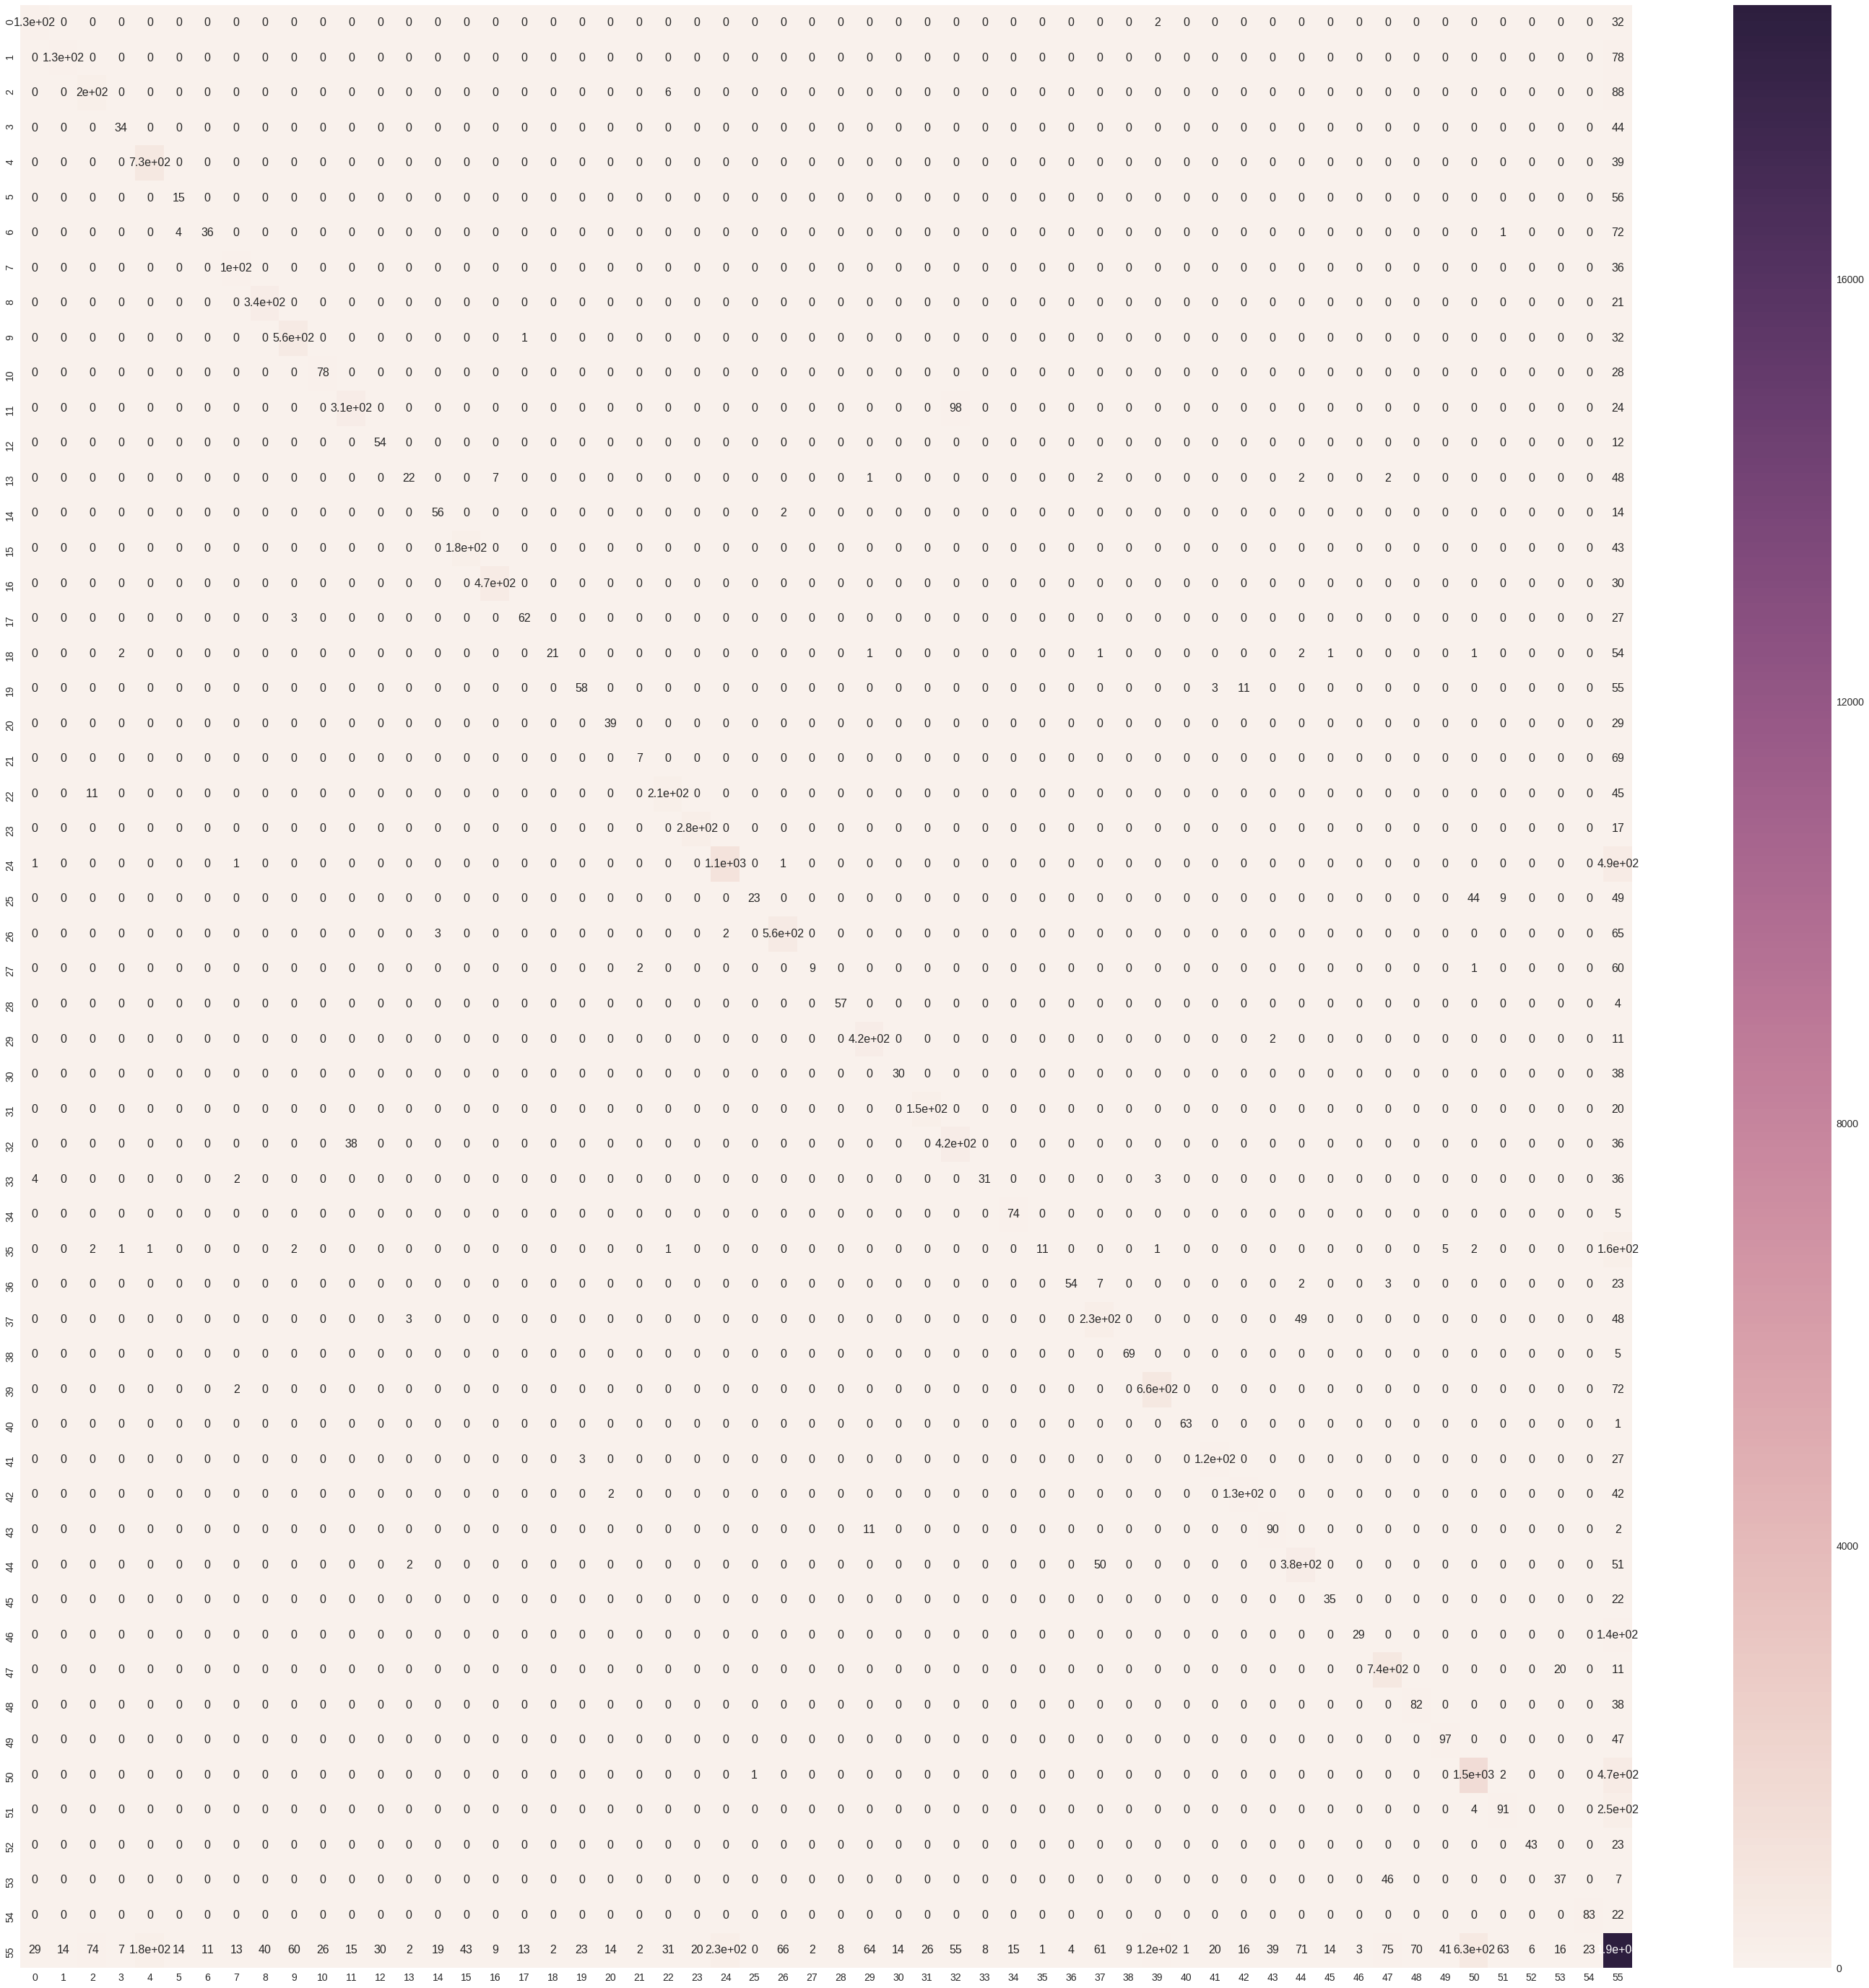

In [37]:
df_cm = pd.DataFrame(results, range(56),
                  range(56))
a4_dims=(50,50)
fig,ax=plt.subplots()
fig.set_size_inches(a4_dims)
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})

# THE END